In [276]:
#didn't want to use notebook space for package installation logs so,
#writing to a log file to see in case there is an error
!apt install -y swig >> apt_logs.txt
!pip install smac[all] >> pip_logs.txt



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [277]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [278]:
import warnings
warnings.filterwarnings('ignore')
#ignore because sometimes MLP doesn't converge and
#it starts prompting about it, it gets annoying sometimes
#especially in the last exercise.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from typing import  List, Union, Type, Callable

%matplotlib inline

In [279]:
BIG_SEED = 123456789 #random seed for later

from sklearn.metrics import accuracy_score, make_scorer
def weighted_score(y_true, y_pred):
    weight = [0.12 if y==0 else 0.88 for y in y_true]
    return accuracy_score(y_true, y_pred, sample_weight=weight)
score_metric = make_scorer(weighted_score)
#score_metric = 'accuracy' #to choose accuracy as the metric
label_metric = 'Weighted Accuracy'

In [280]:
df = pd.read_csv('fertility.csv', skiprows=[0] ,
                 names=['Season','Age','Childish diseases','Accident or trauma',
                        'Surgical intervention','High fevers',
                        'Frequency of alcohol consumption','Smoking habit' ,
                        'Hours spent sitting per day','Class'])
df.head()

,Season,Age,Childish diseases,Accident or trauma,Surgical intervention,High fevers,Frequency of alcohol consumption,Smoking habit,Hours spent sitting per day,Class
0,spring,30,no,yes,yes,more than 3 months ago,once a week,occasional,16,Normal
1,spring,35,yes,no,yes,more than 3 months ago,once a week,daily,6,Altered
2,spring,27,yes,no,no,more than 3 months ago,hardly ever or never,never,9,Normal
3,spring,32,no,yes,yes,more than 3 months ago,hardly ever or never,never,7,Normal
4,spring,30,yes,yes,no,more than 3 months ago,once a week,never,9,Altered


In [281]:
df = pd.get_dummies(df, columns=['Season','Frequency of alcohol consumption'])

encode_col =['Childish diseases','Accident or trauma',
             'Surgical intervention','High fevers', 'Class',
             'Smoking habit', 'Hours spent sitting per day']

for col in encode_col:
    le = LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])
    
df.Class = 1 - df.Class

In [282]:
print(len(df))
df.head()

100


,Age,Childish diseases,Accident or trauma,Surgical intervention,High fevers,Smoking habit,Hours spent sitting per day,Class,Season_fall,Season_spring,Season_summer,Season_winter,Frequency of alcohol consumption_every day,Frequency of alcohol consumption_hardly ever or never,Frequency of alcohol consumption_once a week,Frequency of alcohol consumption_several times a day,Frequency of alcohol consumption_several times a week
0,30,0,1,1,1,2,11,0,0,1,0,0,0,0,1,0,0
1,35,1,0,1,1,0,4,1,0,1,0,0,0,0,1,0,0
2,27,1,0,0,1,1,7,0,0,1,0,0,0,1,0,0,0
3,32,0,1,1,1,1,5,0,0,1,0,0,0,1,0,0,0
4,30,1,1,0,1,1,7,1,0,1,0,0,0,0,1,0,0


In [283]:
df.Class.value_counts()
#class imbalance problem!!

0    88
1    12
Name: Class, dtype: int64

In [284]:
X = df.drop('Class', axis=1).values
y = df.Class

In [285]:
X.shape

(100, 16)

## GP with LCB and EI

In [286]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import shuffle

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter,\
                                        UniformIntegerHyperparameter

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO #Random Forest
from smac.facade.smac_bo_facade import SMAC4BO   #GP
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer import acquisition

In [365]:
def optimizer(surrogate_model :str, 
              config_space :Type[ConfigurationSpace],
              obj_function :Type[Callable],
              acquisition_type :str,
              n_iter :int = 10,
              init_points :int = 0,
              seed :int=None) -> Union[Type[SMAC4BO], Type[SMAC4HPO]]:
    """
    It is just a small wrapper to simplify and make more intuitive 
    the SMAC optimization for ML algorithms for this assignment.
    PARAMETERS
    ----------
    @surrogate_model  can be 'gp' for GaussianProcess or 
                      'rf' for RandomForest
    @config_space     an object of type ConfigSpace containing 
                      information regarding the hyperparameters
    @obj_function     the objective function that needs to be minimized 
    @acquisition_type can be 'LCB', 'EI' or 'PI' and indicated the type 
                      of acquisition function to be used, if the value 
                      is different from 'LCB', 'EI' or 'PI' it will use 
                      the default acquisition function of SMAC.
    @n_iter           number of iterations to do, defaults to 10 iterations
    @init_points      number of initial points, defaults to 0 initial points
    @seed             fix the seed for most of the randomness to have 
                      reproducible results
    
    RETURN
    ------
    either an optimized SMAC4BO object if 'gp' model_type was chosen 
    or an optimized SMAC4HPO object if 'rf' model_type was chosen
    and in any other case an exception (ValueError) is raised
    """
    #create the scenario required by SMAC optimizers
    #First we write down it's values in a dictionary and comment the results
    if seed is None:
        deterministic = "false"
    else:
        deterministic = "true"
    scen_dict = {"run_obj": "quality",    # we optimize quality
            #the only two choises are quality and runtime
            "runcount-limit": n_iter,# number iterations
            "cs": cs,      # configuration space
            "output_dir": "logs",    # create a log folder 
            #named 'logs' to save the logs of SMAC
            "deterministic": deterministic, #if false the model
            #may need to revaluate the same points more time
            #to be sure of the value at that specific point
            "abort_on_first_run_crash": False, #continue in case of a crash instead
            #of failing the model itself, this way the model doesn't crash
            "always_race_default": False
            }
    scenario = Scenario(scenario=scen_dict)
    
    #initial random points can also be created from the 
    #configuration space itself and the seed can be fixed if necessary
    #cs.seed(seed)
    #init = cs.sample_configuration(init_points)
    
    #choose the acquisition function
    #only the one explained at the lessons are present here
    if acquisition_type == 'LCB':
        print('Using LCB acquisition Function')
        _acquistion = acquisition.LCB
    elif acquisition_type == 'EI':
        print('Using EI acquisition Function')
        _acquistion = acquisition.EI
    elif acquisition_type == 'PI':
        print('Using PI acquisition Function')
        _acquistion = acquisition.PI
    else:
        #use the defualt one chosen by SMAC based on the 
        #type of surrogate model chosen
        print('Using SMAC Default acquisition Function')
        _acquistion = None
        
    #choose and optimize the SMAC model
    if surrogate_model == 'gp':
        #use SMAC4BO
        smac = SMAC4BO(scenario=scenario, tae_runner=obj_function, 
                       rng=np.random.RandomState(seed),
                       initial_design=RandomConfigurations, 
                       initial_design_kwargs={'n_configs_x_params':init_points,
                                              'max_config_fracs':init_points/n_iter},
                       acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    if surrogate_model == 'rf':
        #use SMAC4HPO (Bayesian Optimization with Random Forest)
        smac = SMAC4HPO(scenario=scenario, tae_runner=obj_function, 
                        rng=np.random.RandomState(seed),
                        initial_design=RandomConfigurations, 
                        initial_design_kwargs={'n_configs_x_params':init_points,
                                               'max_config_fracs':init_points/n_iter}, 
                        acquisition_function=_acquistion)
        _best = smac.optimize()
        print('Best Configuration found:')
        print(_best)
        return smac
    #in case model_type was neither gp nor rf
    raise ValueError("Model type can only 'gp' or 'rf'")

In [288]:
#SMAC needs a Configuration Space where it will search for the hyperparameters
cs = ConfigurationSpace()

#define the domain of each hyperparameter
lr = UniformFloatHyperparameter("learning_rate_init", 0.01, 0.1, default_value=0.05)
momentum = UniformFloatHyperparameter("momentum", 0.1, 0.9, default_value=0.5)

#add the hyperparameters to the configuration space
cs.add_hyperparameters([lr, momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.05,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

In [289]:
def MLP_score_1(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    MLPclf = MLPClassifier(hidden_layer_sizes=(4,2,), momentum = conf['momentum'],
                          learning_rate_init = conf['learning_rate_init'],
                          random_state=BIG_SEED)
    
    skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED,shuffle=True)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    print("Trying lr:", conf['learning_rate_init'], "momentum:", conf['momentum'], ", got score:", np.mean(score))
    return 1 - np.mean(score) #Error metric

The ‘GP’ surrogate model (SMAC4BO) is chosen for this part, and the acquisition functions ‘EI’, ‘LCB’ and ‘PI’ are used with 5 initial points, and
the iterations are set to 25(20 + 5 initial).

The MultiLayer perceptron classifier has two hidden layers with 4 and 2 neurons respectively and all the other configuration are the default one, except
for the seed which is fixed to have consistent results

In [290]:
#Use gp and LCB
smac_LCB = optimizer('gp', cs, obj_function=MLP_score_1, 
                     acquisition_type='LCB', n_iter=25, 
                     init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
# plt.plot(1 - smac_LCB.get_X_y()[1])
# plt.ylabel(label_metric)
# plt.xlabel('Iterations')
# plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using LCB acquisition Function
Trying lr: 0.07667009068825471 momentum: 0.7805716891438979 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4886


Trying lr: 0.06658675702750029 momentum: 0.5493709311496796 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.531439 sec, available: 0.000010 sec)


Trying lr: 0.041165842289022786 momentum: 0.1826981362622868 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4712) is better than incumbent (0.4886) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.07667009068825471 -> 0.041165842289022786
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7805716891438979 -> 0.1826981362622868
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.531707 sec, available: 0.000010 sec)


Trying lr: 0.05884671019626774 momentum: 0.8407055852339448 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.329627 sec, available: 0.000010 sec)


Trying lr: 0.058743523672522155 momentum: 0.383758098713217 , got score: 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.342770 sec, available: 0.000010 sec)


Trying lr: 0.036677733689172855 momentum: 0.17973977752993667 , got score: 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.357165 sec, available: 0.000010 sec)


Trying lr: 0.04254078821517056 momentum: 0.18272541836426537 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.420506 sec, available: 0.000010 sec)


Trying lr: 0.04157517118118971 momentum: 0.6006539088586864 , got score: 0.5216986794717887


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.465123 sec, available: 0.000010 sec)


Trying lr: 0.03981509206702288 momentum: 0.18468204449312084 , got score: 0.5199879951980794


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.507505 sec, available: 0.000010 sec)


Trying lr: 0.041666361892072235 momentum: 0.1809603990613763 , got score: 0.5393457382953182


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4607) is better than incumbent (0.4712) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.041165842289022786 -> 0.041666361892072235
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.1826981362622868 -> 0.1809603990613763
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.448324 sec, available: 0.000010 sec)


Trying lr: 0.041978207955444845 momentum: 0.1788835843847939 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.395635 sec, available: 0.000010 sec)


Trying lr: 0.035016742346391856 momentum: 0.47983478108494304 , got score: 0.5025810324129651


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.465050 sec, available: 0.000010 sec)


Trying lr: 0.04145138551827715 momentum: 0.18035177712548378 , got score: 0.5305222088835535


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.489537 sec, available: 0.000010 sec)


Trying lr: 0.04069475006307076 momentum: 0.1758876437384715 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.558807 sec, available: 0.000010 sec)


Trying lr: 0.023688806039361663 momentum: 0.8959577983665621 , got score: 0.4937575030012005


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.764513 sec, available: 0.000010 sec)


Trying lr: 0.04321847728876028 momentum: 0.17737047860667723 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.389222 sec, available: 0.000010 sec)


Trying lr: 0.030334927917248823 momentum: 0.10066492401844007 , got score: 0.5008703481392558


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.892481 sec, available: 0.000010 sec)


Trying lr: 0.043761105904679444 momentum: 0.1732053798148651 , got score: 0.49816926770708286


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.546404 sec, available: 0.000010 sec)


Trying lr: 0.04178914067669281 momentum: 0.21715978018881052 , got score: 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.628093 sec, available: 0.000010 sec)


Trying lr: 0.04467921745773096 momentum: 0.18094521198120503 , got score: 0.5199879951980793


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.589688 sec, available: 0.000010 sec)


Trying lr: 0.04165469615571363 momentum: 0.18760126213687975 , got score: 0.5349339735894358


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.462249 sec, available: 0.000010 sec)


Trying lr: 0.04294176399083728 momentum: 0.18798955417471086 , got score: 0.5349339735894357


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.400508 sec, available: 0.000010 sec)


Trying lr: 0.041666361892072235 momentum: 0.12057286590222563 , got score: 0.5393457382953182


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.486778 sec, available: 0.000010 sec)


Trying lr: 0.041949952639545124 momentum: 0.11853716334347139 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.417047 sec, available: 0.000010 sec)


Trying lr: 0.04107265748013863 momentum: 0.12248691653254572 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.546927 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 2
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Configurations: 25
INFO:smac.stats.stats.Stats:Used wallclock time: 46.36 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 11.71 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  learning_rate_init, Value: 0.041666361892072235
  momentum, Value: 0.1809603990613763

INFO:smac.facade.smac_bo_facade.SMAC4BO:Estimated cost of incumbent: 0.460654


Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.041666361892072235
  momentum, Value: 0.1809603990613763



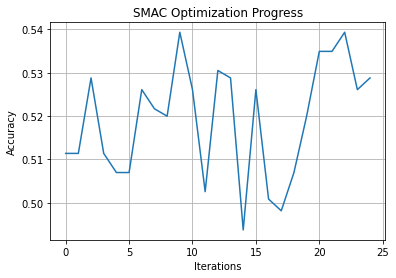

In [291]:
runhistory = smac_LCB.runhistory

# Get performance values (lower is better for SMAC by default)
GP_LCB_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# If you want to convert to accuracy:
accuracies = [1 - c for c in GP_LCB_costs]

# Plot it
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('SMAC Optimization Progress')
plt.grid()
plt.show()


In [292]:
#Use gp and EI
smac_EI = optimizer('gp', cs, obj_function=MLP_score_1, 
                    acquisition_type='EI', n_iter=25, 
                    init_points=5, seed=BIG_SEED)
# plot the value for each iteration done
# plt.plot(1 - smac_EI.get_X_y()[1])
# plt.ylabel(label_metric)
# plt.xlabel('Iterations')
# plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using EI acquisition Function
Trying lr: 0.07667009068825471 momentum: 0.7805716891438979 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4886


Trying lr: 0.06658675702750029 momentum: 0.5493709311496796 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.547917 sec, available: 0.000010 sec)


Trying lr: 0.041165842289022786 momentum: 0.1826981362622868 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4712) is better than incumbent (0.4886) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.07667009068825471 -> 0.041165842289022786
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7805716891438979 -> 0.1826981362622868
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.516948 sec, available: 0.000010 sec)


Trying lr: 0.05884671019626774 momentum: 0.8407055852339448 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.331009 sec, available: 0.000010 sec)


Trying lr: 0.058743523672522155 momentum: 0.383758098713217 , got score: 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.338977 sec, available: 0.000010 sec)


Trying lr: 0.04109493358230219 momentum: 0.18404030843852204 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.570827 sec, available: 0.000010 sec)


Trying lr: 0.03999812837404114 momentum: 0.10054045999528977 , got score: 0.5243997599039617


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.550992 sec, available: 0.000010 sec)


Trying lr: 0.04124732031187897 momentum: 0.4113266068597733 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.512555 sec, available: 0.000010 sec)


Trying lr: 0.0271011504961767 momentum: 0.5346093607494494 , got score: 0.5243997599039616


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.072051 sec, available: 0.000010 sec)


Trying lr: 0.0315771561499589 momentum: 0.826473216930568 , got score: 0.5243997599039616


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.975104 sec, available: 0.000010 sec)


Trying lr: 0.041204061253441365 momentum: 0.29163728144461243 , got score: 0.4832232893157264


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.528451 sec, available: 0.000010 sec)


Trying lr: 0.04086154877468656 momentum: 0.4352257417157118 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.527489 sec, available: 0.000010 sec)


Trying lr: 0.03830919211014132 momentum: 0.16205204649412255 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.495669 sec, available: 0.000010 sec)


Trying lr: 0.032532635738581214 momentum: 0.4218824617268814 , got score: 0.5199879951980793


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.755390 sec, available: 0.000010 sec)


Trying lr: 0.026677471728877793 momentum: 0.3237785248237499 , got score: 0.5243997599039616


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.045999 sec, available: 0.000010 sec)


Trying lr: 0.043846327410085074 momentum: 0.42489923632771176 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.403750 sec, available: 0.000010 sec)


Trying lr: 0.01763713301342862 momentum: 0.33558181417816146 , got score: 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.124813 sec, available: 0.000010 sec)


Trying lr: 0.04108500745469664 momentum: 0.4238325886820895 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.533947 sec, available: 0.000010 sec)


Trying lr: 0.04091769614486281 momentum: 0.496271755602558 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.516696 sec, available: 0.000010 sec)


Trying lr: 0.04911819794874416 momentum: 0.16577074412454812 , got score: 0.5216986794717887


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.436010 sec, available: 0.000010 sec)


Trying lr: 0.03549813542023527 momentum: 0.576027069183031 , got score: 0.5305222088835534


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4695) is better than incumbent (0.4712) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.041165842289022786 -> 0.03549813542023527
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.1826981362622868 -> 0.576027069183031
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.474831 sec, available: 0.000010 sec)


Trying lr: 0.03622774423874645 momentum: 0.5418517396593873 , got score: 0.5216986794717887


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.556195 sec, available: 0.000010 sec)


Trying lr: 0.03480050651758679 momentum: 0.610536034546858 , got score: 0.5305222088835534


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.548160 sec, available: 0.000010 sec)


Trying lr: 0.03390367300349085 momentum: 0.5905221302574967 , got score: 0.5216986794717887


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.544873 sec, available: 0.000010 sec)


Trying lr: 0.03622391238749988 momentum: 0.6136692306387872 , got score: 0.526110444177671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.578884 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 2
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Configurations: 25
INFO:smac.stats.stats.Stats:Used wallclock time: 53.32 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 14.24 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  learning_rate_init, Value: 0.03549813542023527
  momentum, Value: 0.576027069183031

INFO:smac.facade.smac_bo_facade.SMAC4BO:Estimated cost of incumbent: 0.469478


Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.03549813542023527
  momentum, Value: 0.576027069183031



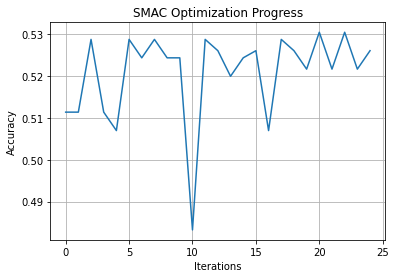

In [293]:
runhistory = smac_EI.runhistory

# Get performance values (lower is better for SMAC by default)
GP_EI_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# If you want to convert to accuracy:
accuracies = [1 - c for c in GP_EI_costs]

# Plot it
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('SMAC Optimization Progress')
plt.grid()
plt.show()


In [294]:
#Use gp and PI
smac_PI = optimizer('gp', cs, obj_function=MLP_score_1, 
                    acquisition_type='PI', n_iter=25, 
                    init_points=5, seed=BIG_SEED)
#plot the value for each iteration done
# plt.plot(1 - smac_PI.get_X_y()[1])
# plt.ylabel(label_metric)
# plt.xlabel('Iterations')
# plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using PI acquisition Function
Trying lr: 0.07667009068825471 momentum: 0.7805716891438979 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4886


Trying lr: 0.06658675702750029 momentum: 0.5493709311496796 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.525079 sec, available: 0.000010 sec)


Trying lr: 0.041165842289022786 momentum: 0.1826981362622868 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4712) is better than incumbent (0.4886) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.07667009068825471 -> 0.041165842289022786
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7805716891438979 -> 0.1826981362622868
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.525399 sec, available: 0.000010 sec)


Trying lr: 0.05884671019626774 momentum: 0.8407055852339448 , got score: 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.327670 sec, available: 0.000010 sec)


Trying lr: 0.058743523672522155 momentum: 0.383758098713217 , got score: 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.352287 sec, available: 0.000010 sec)


Trying lr: 0.04115389320734765 momentum: 0.18274994423142524 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.550117 sec, available: 0.000010 sec)


Trying lr: 0.04106484916408687 momentum: 0.1827147232130856 , got score: 0.5243997599039616


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.629254 sec, available: 0.000010 sec)


Trying lr: 0.041161846299344 momentum: 0.18291658926336823 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.540080 sec, available: 0.000010 sec)


Trying lr: 0.04115913926912694 momentum: 0.1827315705497748 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.550850 sec, available: 0.000010 sec)


Trying lr: 0.04115913926912694 momentum: 0.1828473944330915 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.551750 sec, available: 0.000010 sec)


Trying lr: 0.041165842289022786 momentum: 0.18445849423335842 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.538735 sec, available: 0.000010 sec)


Trying lr: 0.04115631312074622 momentum: 0.18261153307219108 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.542679 sec, available: 0.000010 sec)


Trying lr: 0.041155722699626675 momentum: 0.18442346665814563 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.549407 sec, available: 0.000010 sec)


Trying lr: 0.041155722699626675 momentum: 0.18341413427888079 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.545510 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.18274994423142524 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.522713 sec, available: 0.000010 sec)


Trying lr: 0.041155722699626675 momentum: 0.18272552805003361 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.558815 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.18408307149434022 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.524354 sec, available: 0.000010 sec)


Trying lr: 0.04116499599442566 momentum: 0.1836005668096588 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.521463 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.18241916363492072 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.521484 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.18295810868342532 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.533845 sec, available: 0.000010 sec)


Trying lr: 0.04115913926912694 momentum: 0.1839627775453645 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.545589 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.1833087561265906 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.521343 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.18325069890544843 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.523926 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.18279397597238753 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.524752 sec, available: 0.000010 sec)


Trying lr: 0.04115476070922967 momentum: 0.18284123107441852 , got score: 0.528811524609844


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.520528 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 25 / 25.0
INFO:smac.stats.stats.Stats:#Configurations: 25
INFO:smac.stats.stats.Stats:Used wallclock time: 51.21 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 12.30 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  learning_rate_init, Value: 0.041165842289022786
  momentum, Value: 0.1826981362622868

INFO:smac.facade.smac_bo_facade.SMAC4BO:Estimated cost of incumbent: 0.471188


Best Configuration found:
Configuration:
  learning_rate_init, Value: 0.041165842289022786
  momentum, Value: 0.1826981362622868



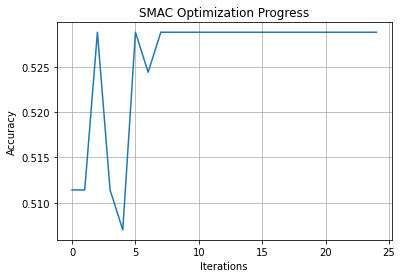

In [295]:
runhistory = smac_PI.runhistory

# Get performance values (lower is better for SMAC by default)
GP_PI_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# If you want to convert to accuracy:
accuracies = [1 - c for c in GP_PI_costs]

# Plot it
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('SMAC Optimization Progress')
plt.grid()
plt.show()


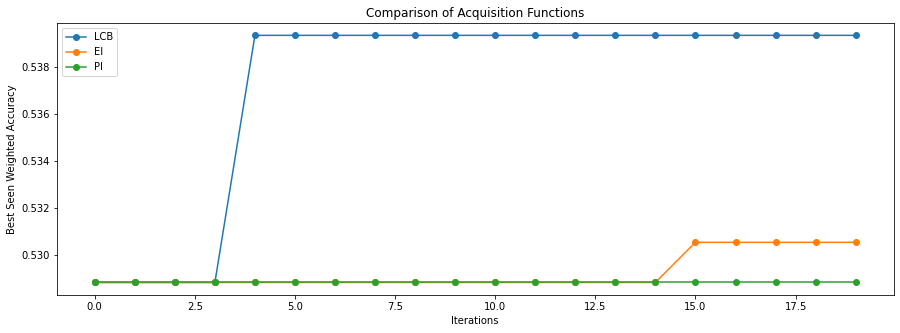

In [296]:
import numpy as np
import matplotlib.pyplot as plt

def extract_costs(runhistory, skip=5):
    # Extract costs in the order they were added
    costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]
    # Compute best-seen so far
    best_seen = np.minimum.accumulate(costs)
    # Return after skipping initial random points
    return 1 - np.array(best_seen[skip:])

# Extract best-seen curves
lcbs = extract_costs(smac_LCB.runhistory)
eis = extract_costs(smac_EI.runhistory)
pis = extract_costs(smac_PI.runhistory)

# Plotting
plt.figure(figsize=(15,5))
plt.plot(lcbs, 'o-')
plt.plot(eis, 'o-')
plt.plot(pis, 'o-')
plt.legend(['LCB','EI','PI'])
plt.ylabel('Best Seen ' + label_metric)
plt.xlabel('Iterations')
plt.title('Comparison of Acquisition Functions')
plt.show()


In [297]:
# #Compare the two models removing the initial 5 points keeping only the best of them.
# plt.figure(figsize=(15,5))
# plt.plot(1-np.minimum.accumulate(GP_LCB_costs[1])[4:], 'o-') #0,1,2,3,4 sono i punti iniziali
# plt.plot(1-np.minimum.accumulate(GP_EI_costs[1])[4:], 'o-')
# plt.plot(1-np.minimum.accumulate(GP_PI_costs[1])[4:], 'o-')
# plt.legend(['LCB','EI','PI'])
# plt.ylabel('Best Seen '+label_metric)
# plt.xlabel('Iterations')
# plt.show()

## Grid and Randomized Search

For the GridSearch evenly distributed points are taken from the Configuration Domain (5 for each parameter), and RadomSearch searches random
points by itself.

In [298]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time

In [299]:
#create the configuration grid with 5 element for each hyperparameter
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5)}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1) #n_jobs=-1 parallelize the computation

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED,shuffle=True)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_, "->", MLP_GS.best_score_)
print("Completed in %0.3fs" % (time() - t_0))

{'learning_rate_init': 0.0775, 'momentum': 0.1} -> 0.5114045618247298
Completed in 6.650s


Best Score 0.5114045618247298


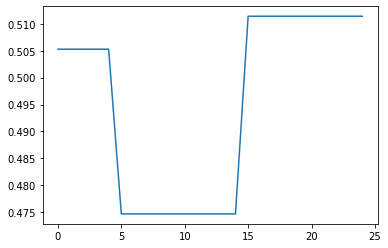

In [300]:
print("Best Score", np.max(MLP_GS.cv_results_['mean_test_score']))
plt.plot(MLP_GS.cv_results_['mean_test_score'])
plt.show()

In [301]:
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9)}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=25, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED,shuffle=True)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_, "->", MLP_RS.best_score_)
print("Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.7857142857142857, 'learning_rate_init': 0.026530612244897958} -> 0.5379351740696278
Completed in 4.682s


Best Score 0.5379351740696278


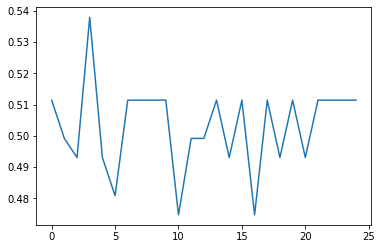

In [302]:
print("Best Score", np.max(MLP_RS.cv_results_['mean_test_score']))
plt.plot(MLP_RS.cv_results_['mean_test_score'])
plt.show()

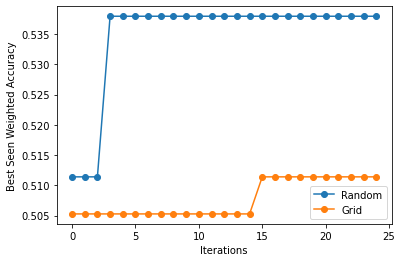

In [303]:
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

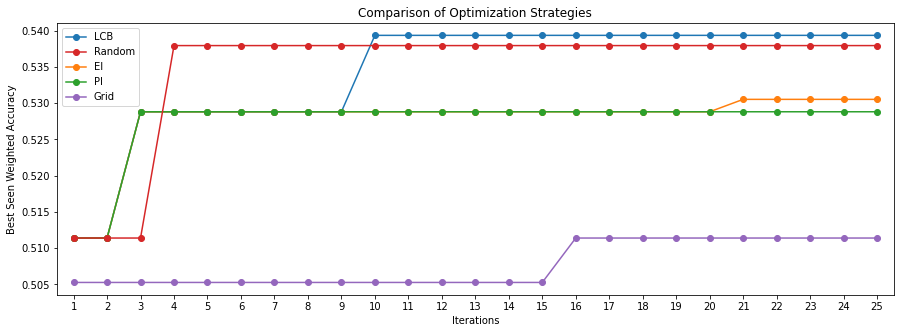

In [304]:
plt.figure(figsize=(15, 5))
iter_num = list(range(1, 26))  # 25 iterations

# Compute 1 - cost and cumulative best seen
lcb = plt.plot(iter_num, 1 - np.minimum.accumulate(GP_LCB_costs), 'o-')[0]
ei  = plt.plot(iter_num, 1 - np.minimum.accumulate(GP_EI_costs), 'o-')[0]
pi  = plt.plot(iter_num, 1 - np.minimum.accumulate(GP_PI_costs), 'o-')[0]

# Best seen test scores (already accuracy) for Random Search and Grid Search
rs  = plt.plot(iter_num, np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score'][:25]), 'o-')[0]
gs  = plt.plot(iter_num, np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score'][:25]), 'o-')[0]

# Optional: sort legend by final performance
lines = [lcb, rs, ei, pi, gs]
labels = ['LCB', 'Random', 'EI', 'PI', 'Grid']
final_scores = [
    (1 - np.minimum.accumulate(GP_LCB_costs))[-1],
    np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score'][:25])[-1],
    (1 - np.minimum.accumulate(GP_EI_costs))[-1],
    (1 - np.minimum.accumulate(GP_PI_costs))[-1],
    np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score'][:25])[-1]
]
# Sort by descending performance
sorted_items = sorted(zip(final_scores, lines, labels), reverse=True)
sorted_lines, sorted_labels = zip(*[(l, lab) for _, l, lab in sorted_items])

# Plot legend
plt.legend(sorted_lines, sorted_labels)
plt.ylabel('Best Seen ' + label_metric)
plt.xlabel('Iterations')
plt.xlim(xmin=0.5, xmax=25.5)
plt.xticks(iter_num)
plt.title('Comparison of Optimization Strategies')
plt.show()


In [305]:
# plt.figure(figsize=(15,5))
# iter_num = list(range(1,26))
# lcb, = plt.plot(iter_num, 1-np.minimum.accumulate(GP_LCB_costs[1]), 'o-')
# ei,  = plt.plot(iter_num, 1-np.minimum.accumulate(GP_EI_costs[1]), 'o-')
# pi,  = plt.plot(iter_num, 1-np.minimum.accumulate(GP_PI_costs[1]), 'o-')
# rs,  = plt.plot(iter_num, np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
# gs,  = plt.plot(iter_num, np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
# plt.legend([lcb,rs,ei, pi, gs],['LCB','Random','EI','PI','Grid']) #need to change order based on the score
# plt.ylabel('Best Seen '+label_metric)
# plt.xlabel('Iterations')
# plt.xlim(xmin=0.5, xmax=25.5)
# plt.xticks(iter_num)
# plt.show()

Let's see the best model found by LCB
The grid search performs ok because this is a small dimensional hyperparameter space (2 dimensions), as we increase the dimension the more difficult it gets.

In [306]:
# Extract all config keys and their corresponding costs
configs = list(smac_LCB.runhistory.data.keys())
costs = [v.cost for v in smac_LCB.runhistory.data.values()]

# Find the index of the lowest cost
best_index = np.argmin(costs)

# Extract the config ID (first element of the tuple: (config_id, seed, budget))
best_config_key = configs[best_index][0]

# Fetch the actual configuration object using the ID
best_config = smac_LCB.runhistory.ids_config[best_config_key]

# Now extract learning rate and momentum
best_lr = best_config["learning_rate_init"]          # or use your actual param name if it's different
best_momentum = best_config["momentum"]

# Store in tuple or list as needed
best_1 = [best_lr, best_momentum]

print("Best Config:", best_config)
print("Best Learning Rate:", best_1[0])
print("Best Momentum:", best_1[1])


Best Config: Configuration:
  learning_rate_init, Value: 0.041666361892072235
  momentum, Value: 0.1809603990613763

Best Learning Rate: 0.041666361892072235
Best Momentum: 0.1809603990613763


In [307]:
best_1[0]

0.041666361892072235

In [308]:
from sklearn.model_selection import cross_validate

MLPclf = MLPClassifier(hidden_layer_sizes=(4, 2),
                      learning_rate_init=best_1[0], momentum=best_1[1],
                      random_state=BIG_SEED)

skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED,shuffle=True)
scores = cross_validate(MLPclf, df.drop('Class', axis=1).values, df.Class, cv=skf,
                        scoring=['f1','precision','recall','f1_macro','accuracy'])

In [309]:
print("F1:\t\t %0.3f" % (np.mean(scores['test_f1'])))
print("Precision:\t %0.3f" % (np.mean(scores['test_precision'])))
print("Recall:\t\t %0.3f" % (np.mean(scores['test_recall'])))
print("F1 Macro:\t %0.3f" % (np.mean(scores['test_f1_macro'])))
print("Accuracy:\t %0.3f" % (np.mean(scores['test_accuracy'])))

F1:		 0.067
Precision:	 0.100
Recall:		 0.050
F1 Macro:	 0.501
Accuracy:	 0.880


In [310]:
best_1

[0.041666361892072235, 0.1809603990613763]

First of all, it is important to notice that maximing weighted accuracy the model achieved good performance also on accuracy and that the model doesn't follow the zero rule, now we will plot the results in a contour plot to see how he searched the space, the in the next section we will use more iterations to see if we can improve the model even more.

In [311]:
def extract_cost_config(runhistory):
    configs = []
    costs = []
    for runkey, runvalue in runhistory.data.items():
        config = runhistory.ids_config[runkey.config_id]
        configs.append(config.get_dictionary())
        costs.append(runvalue.cost)
    return configs, costs


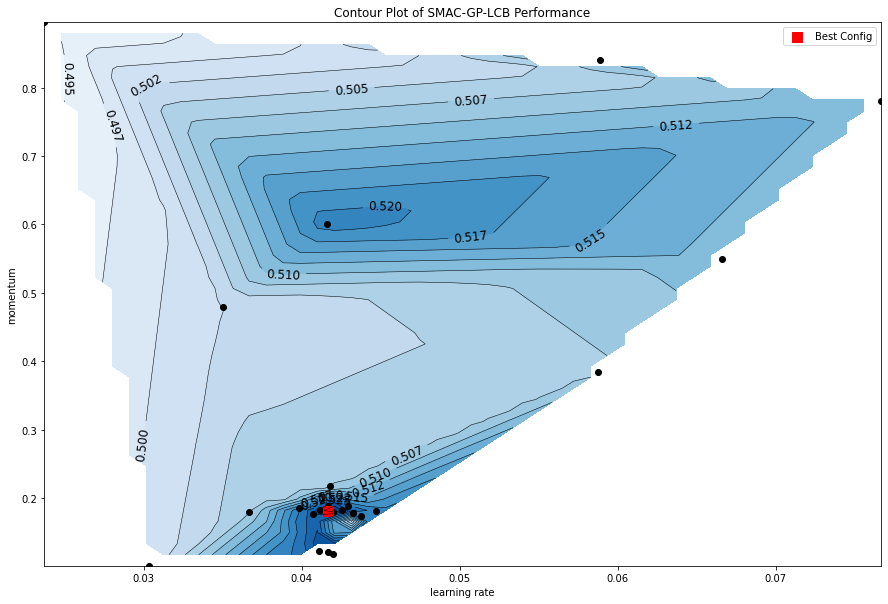

In [312]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

# Extract from runhistory
configs, costs = extract_cost_config(smac_LCB.runhistory)

# Pull out hyperparameter values (adjust names if needed)
x = [cfg['learning_rate_init'] for cfg in configs]
y = [cfg['momentum'] for cfg in configs]
z = [1 - c for c in costs]  # maximize score

# Define grid
xi = np.linspace(min(x), max(x), 50)
yi = np.linspace(min(y), max(y), 50)
zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

# Get best config
best_idx = np.argmax(z)
best_x, best_y = x[best_idx], y[best_idx]

# Plot
plt.figure(figsize=(15, 10))
CS1 = plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
CS = plt.contourf(xi, yi, zi, 15, cmap=plt.cm.Blues)
plt.clabel(CS1, inline=1, fontsize=12)

plt.scatter(x, y, color='black')
plt.scatter(best_x, best_y, color='red', marker='s', s=100, label='Best Config')
plt.xlabel('learning rate')
plt.ylabel('momentum')
plt.title('Contour Plot of SMAC-GP-LCB Performance')
plt.legend()
plt.show()


In [313]:
# from scipy.interpolate import griddata
# plt.figure(figsize=(15,10))
# best_1 = smac_LCB.get_X_y()[0][np.argmin(smac_LCB.get_X_y()[1])]
# x = list(map(lambda x: x[0],smac_LCB.get_X_y()[0]))
# y = list(map(lambda x: x[1],smac_LCB.get_X_y()[0]))
# z = 1 - smac_LCB.get_X_y()[1]
# # define grid.
# xi = np.linspace(0.01,0.1,50)
# yi = np.linspace(0.1,0.9,50)
# # grid the data.
# zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
# # contour the gridded data, plotting dots at the randomly spaced data points.
# CS1 = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
# CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.Blues)
# #plt.colorbar()
# plt.clabel(CS1, inline=1, fontsize=12)

# plt.scatter(x, y, color='black')
# plt.scatter(best_1[0], best_1[1], color='red', marker='s', linewidths=6)
# plt.xlabel('learning rate')
# plt.ylabel('momentum')
# plt.title('Counter Plot')
# #plt.savefig('./imgs/counter_weighted.png')
# plt.show()

## Random Forest with LBC and EI

In [314]:
hidden1 = UniformIntegerHyperparameter('h1',1,5)
hidden2 = UniformIntegerHyperparameter('h2',1,5)

cs.add_hyperparameters([hidden1, hidden2])

[h1, Type: UniformInteger, Range: [1, 5], Default: 3,
 h2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [315]:
def MLP_score_2(conf: Union[Type[ConfigurationSpace], dict]) -> float:
    """
    Basically takes a configuration does a 10-CV and return the average
    score, the average score is modified so it gets minimized, for example
    accuracy is converted into error.
    PARAMETERS
    ----------
    @conf   is a ConfigurationSpace Object, but it acts as a dictionary
            so we can call a value given the key: conf['key']
            
    Returns
    -------
    @return a float value which needs to be minimized in this case cv error
    
    This function takes in the configuration and computes the error score
    using CV with 10 folds
    """
    
    MLPclf = MLPClassifier(hidden_layer_sizes=(conf['h1'],conf['h2'],), 
                           momentum = conf['momentum'],
                           learning_rate_init = conf['learning_rate_init'],
                           random_state=BIG_SEED)
    
    skf = StratifiedKFold(n_splits=10)
    X = df.drop('Class', axis=1).values
    y = df.Class
    score = cross_val_score(MLPclf, X, y, cv=skf, scoring=score_metric)
    print(conf['learning_rate_init'], conf['momentum'], np.mean(score))
    return 1 - np.mean(score)  # it needs to Minimize it!

In [316]:
#Use rf and EI
smac_rf_EI = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='EI', n_iter=110, 
                    init_points=10, seed=BIG_SEED)
#plot the value for each iteration done
# plt.plot(1 - smac_rf_EI.get_X_y()[1])
# plt.ylabel(label_metric)
# plt.xlabel('Iterations')
# plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using EI acquisition Function
0.0658493035532586 0.49622378515536003 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4886


0.012618343503492146 0.47705287246421413 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.473841 sec, available: 0.000010 sec)


0.08902364504550368 0.8959296824851778 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.182329 sec, available: 0.000010 sec)


0.09272901158847946 0.30735739565586473 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4604) is better than incumbent (0.4886) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 1 -> 4
INFO:smac.intensification.intensification.Intensifier:  h2 : 1 -> 3
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0658493035532586 -> 0.09272901158847946
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.49622378515536003 -> 0.30735739565586473
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.711140 sec, available: 0.000010 sec)


0.03244622958177407 0.6831977862770282 0.4906662665066026


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.894436 sec, available: 0.000010 sec)


0.04199113983559746 0.6035092848134636 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.418892 sec, available: 0.000010 sec)


0.022039751820894724 0.7560266773905412 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.570150 sec, available: 0.000010 sec)


0.0785703399476699 0.5041911331670293 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.234406 sec, available: 0.000010 sec)


0.036991150772512034 0.7720397451945041 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.313989 sec, available: 0.000010 sec)


0.062220121756236646 0.21587027825310054 0.4842136854741897


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.901204 sec, available: 0.000010 sec)


0.09996702016773899 0.4288805703700672 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.747467 sec, available: 0.000010 sec)


0.027459274978012732 0.164594696857207 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.399536 sec, available: 0.000010 sec)


0.04504695639818579 0.13731102139633916 0.49033613445378155


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.951391 sec, available: 0.000010 sec)


0.09985208494375562 0.29219794299753277 0.4947478991596639


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.690814 sec, available: 0.000010 sec)


0.0583189326968319 0.5387313707530147 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.181415 sec, available: 0.000010 sec)


0.09373438036749139 0.3059737417143662 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.183452 sec, available: 0.000010 sec)


0.09347451328041699 0.31187792397093017 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.770442 sec, available: 0.000010 sec)


0.09083659711103181 0.30891123688815103 0.4869147659063625


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.777058 sec, available: 0.000010 sec)


0.09275760735227731 0.3072834670265277 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4498) is better than incumbent (0.4604) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h2 : 3 -> 4
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.09272901158847946 -> 0.09275760735227731
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.30735739565586473 -> 0.3072834670265277
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.757160 sec, available: 0.000010 sec)


0.092800811719332 0.30849984310423106 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.711349 sec, available: 0.000010 sec)


0.09275760735227731 0.3072834670265277 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.521789 sec, available: 0.000010 sec)


0.09275760735227731 0.3072834670265277 0.4491896758703481


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.998046 sec, available: 0.000010 sec)


0.09276501963271407 0.3072834670265277 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.791892 sec, available: 0.000010 sec)


0.06503627996856791 0.34439390224286753 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.209305 sec, available: 0.000010 sec)


0.09266813822232285 0.2818824491489731 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.748296 sec, available: 0.000010 sec)


0.09275760735227731 0.30687575612131557 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.761688 sec, available: 0.000010 sec)


0.09275760735227731 0.30694806821288567 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.754976 sec, available: 0.000010 sec)


0.052507665747168725 0.8110621973538434 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.651431 sec, available: 0.000010 sec)


0.09275760735227731 0.3072284598217867 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.236973 sec, available: 0.000010 sec)


0.09275760735227731 0.30694806821288567 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.511304 sec, available: 0.000010 sec)


0.09275650709070296 0.30687575612131557 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.496953 sec, available: 0.000010 sec)


0.09275760735227731 0.30691282915136997 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.755491 sec, available: 0.000010 sec)


0.09275760735227731 0.3069625967206506 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.162655 sec, available: 0.000010 sec)


0.09275760735227731 0.30607267547582273 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.899745 sec, available: 0.000010 sec)


0.09871706429286418 0.7362498934996601 0.4869147659063625


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.637771 sec, available: 0.000010 sec)


0.09276501963271407 0.30695731959549166 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.754445 sec, available: 0.000010 sec)


0.038662947243936985 0.880409471205945 0.4536014405762304


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.818239 sec, available: 0.000010 sec)


0.08603608716162572 0.7979820134927713 0.47466986794717886


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.843028 sec, available: 0.000010 sec)


0.09275760735227731 0.30677402994337055 0.4947478991596639


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.872350 sec, available: 0.000010 sec)


0.09349447069670364 0.30691282915136997 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.680682 sec, available: 0.000010 sec)


0.09276668697903312 0.30691282915136997 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.766169 sec, available: 0.000010 sec)


0.09275760735227731 0.30607267547582273 0.535234093637455


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.672554 sec, available: 0.000010 sec)


0.09275760735227731 0.30691282915136997 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.492450 sec, available: 0.000010 sec)


0.09275760735227731 0.3061392574209575 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.760595 sec, available: 0.000010 sec)


0.09275760735227731 0.2108711623675593 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.760142 sec, available: 0.000010 sec)


0.09275760735227731 0.20129179336297479 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.753381 sec, available: 0.000010 sec)


0.09275760735227731 0.3062118964206282 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.746209 sec, available: 0.000010 sec)


0.03786715262309858 0.11756906928031291 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.445729 sec, available: 0.000010 sec)


0.09275760735227731 0.2663589011286015 0.4491896758703481


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.017133 sec, available: 0.000010 sec)


0.04278979002047173 0.6839134068302851 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.389720 sec, available: 0.000010 sec)


0.04642424144031421 0.8717097986003258 0.5603841536614645


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4396) is better than incumbent (0.4498) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 4 -> 5
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.09275760735227731 -> 0.04642424144031421
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.3072834670265277 -> 0.8717097986003258
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.963919 sec, available: 0.000010 sec)


0.05225591251249646 0.871026312100048 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.227756 sec, available: 0.000010 sec)


0.03173759874240838 0.8776193068970558 0.5090336134453781


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.874059 sec, available: 0.000010 sec)


0.048439024724225385 0.8752912106552004 0.5478091236494598


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.827621 sec, available: 0.000010 sec)


0.04332804847059215 0.8717827365981284 0.47466986794717875


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.780489 sec, available: 0.000010 sec)


0.04645994272544643 0.8714568522704572 0.5355642256902761


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.881383 sec, available: 0.000010 sec)


0.07586432907459252 0.4444168912181793 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.676916 sec, available: 0.000010 sec)


0.045788473831178005 0.8717097986003258 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.438676 sec, available: 0.000010 sec)


0.04639243645661825 0.876456548716084 0.5583433373349339


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.789067 sec, available: 0.000010 sec)


0.08422296590678295 0.12578526569562093 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.682927 sec, available: 0.000010 sec)


0.04641112788557129 0.8757992134177073 0.5008703481392558


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.488150 sec, available: 0.000010 sec)


0.04642424144031421 0.8721877054758076 0.5603841536614645


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.944401 sec, available: 0.000010 sec)


0.024457463066263924 0.43201578809404506 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.741355 sec, available: 0.000010 sec)


0.04642250855536575 0.8722327601772383 0.5481392557022808


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.921715 sec, available: 0.000010 sec)


0.046171481288713026 0.8720203017341724 0.5743397358943577


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4257) is better than incumbent (0.4396) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.04642424144031421 -> 0.046171481288713026
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8717097986003258 -> 0.8720203017341724
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.860896 sec, available: 0.000010 sec)


0.07374232166760564 0.689061546177357 0.525690276110444


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.995733 sec, available: 0.000010 sec)


0.04588977873877098 0.8727458070022898 0.4413565426170468


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.768243 sec, available: 0.000010 sec)


0.04605812196702775 0.872060654517581 0.4967887154861944


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.866550 sec, available: 0.000010 sec)


0.04617633702836801 0.8719875834652815 0.57875150060024


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4212) is better than incumbent (0.4257) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.046171481288713026 -> 0.04617633702836801
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8720203017341724 -> 0.8719875834652815
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.736784 sec, available: 0.000010 sec)


0.04618692663773816 0.8719875834652815 0.5008703481392558


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.459570 sec, available: 0.000010 sec)


0.030869871829353822 0.7375714585879721 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.294771 sec, available: 0.000010 sec)


0.04612881783451658 0.8719748311501044 0.4828331332533013


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.686579 sec, available: 0.000010 sec)


0.08407895622217773 0.6681231228153377 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.225477 sec, available: 0.000010 sec)


0.04616697855275466 0.8747657788915177 0.4828331332533013


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.774321 sec, available: 0.000010 sec)


0.04617633702836801 0.8719875834652815 0.5008703481392558


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.467315 sec, available: 0.000010 sec)


0.07526539704787363 0.5910959206791009 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.178079 sec, available: 0.000010 sec)


0.04617633702836801 0.8719875834652815 0.5927070828331332


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4073) is better than incumbent (0.4212) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 5 -> 4
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.783051 sec, available: 0.000010 sec)


0.04617633702836801 0.8719875834652815 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.425831 sec, available: 0.000010 sec)


0.023441594707681878 0.5053825833637406 0.5029111644657863


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.977699 sec, available: 0.000010 sec)


0.02579821165652084 0.44040665843406046 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.912065 sec, available: 0.000010 sec)


0.04617633702836801 0.8719875834652815 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.618068 sec, available: 0.000010 sec)


0.09291064676031215 0.8004728141824431 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.551005 sec, available: 0.000010 sec)


0.04617633702836801 0.8721382789907647 0.5927070828331332


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.788558 sec, available: 0.000010 sec)


0.04617633702836801 0.8750303135389949 0.5927070828331332


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.781746 sec, available: 0.000010 sec)


0.06500582367194645 0.6312065066494604 0.4964585834333734


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.811658 sec, available: 0.000010 sec)


0.059766120724582095 0.886254698172237 0.49033613445378155


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.983796 sec, available: 0.000010 sec)


0.049104420195926604 0.8266305391343118 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.503788 sec, available: 0.000010 sec)


0.046171481288713026 0.8769729126120691 0.5498499399759904


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.814030 sec, available: 0.000010 sec)


0.04617633702836801 0.8721382789907647 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.754691 sec, available: 0.000010 sec)


0.046176125314475944 0.8721382789907647 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.913846 sec, available: 0.000010 sec)


0.051119759997201454 0.3105721538775803 0.4842136854741897


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.868941 sec, available: 0.000010 sec)


0.04967697462393418 0.20982717911745655 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.273013 sec, available: 0.000010 sec)


0.0929657219885307 0.8750725216982898 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.700037 sec, available: 0.000010 sec)


0.04617633702836801 0.8721421504330079 0.5927070828331332


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.819179 sec, available: 0.000010 sec)


0.046176125314475944 0.8721382789907647 0.6253601440576231


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3746) is better than incumbent (0.4073) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.04617633702836801 -> 0.046176125314475944
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.8719875834652815 -> 0.8721382789907647
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.849688 sec, available: 0.000010 sec)


0.046176125314475944 0.8721382789907647 0.5399759903961584


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.015346 sec, available: 0.000010 sec)


0.046176125314475944 0.8720736094000705 0.6253601440576231


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.884251 sec, available: 0.000010 sec)


0.01279345867175333 0.6702755583411389 0.6093637454981993


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.104135 sec, available: 0.000010 sec)


0.08746113536495169 0.81931649910833 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.305991 sec, available: 0.000010 sec)


0.046176125314475944 0.87207649558059 0.57875150060024


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.756973 sec, available: 0.000010 sec)


0.03855859446991097 0.2759415214818547 0.4825030012004802


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.438207 sec, available: 0.000010 sec)


0.046176125314475944 0.8720736094000705 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.770431 sec, available: 0.000010 sec)


0.046176125314475944 0.8720736094000705 0.5399759903961584


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.022989 sec, available: 0.000010 sec)


0.08766970088007135 0.7539733192198436 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.504398 sec, available: 0.000010 sec)


0.046176125314475944 0.87207649558059 0.6253601440576231


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.847848 sec, available: 0.000010 sec)


0.061473981912985406 0.18191457189807123 0.4624249699879952


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.884471 sec, available: 0.000010 sec)


0.04034768266210098 0.6785988303345034 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.257942 sec, available: 0.000010 sec)


0.05893919478285683 0.30606682520942863 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.239373 sec, available: 0.000010 sec)


0.041214522195463774 0.87207649558059 0.6015906362545018


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.807829 sec, available: 0.000010 sec)


0.0700287200835846 0.10960159306428459 0.5008703481392558


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.665894 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 7
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 110 / 110.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 110 / 110.0
INFO:smac.stats.stats.Stats:#Configurations: 110
INFO:smac.stats.stats.Stats:Used wallclock time: 120.24 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 72.90 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  h1, Value: 4
  h2, Value: 4
  learning_rate_init, Value: 0.046176125314475944
  momentum, Value: 0.8721382789907647

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Estimated cost

Best Configuration found:
Configuration:
  h1, Value: 4
  h2, Value: 4
  learning_rate_init, Value: 0.046176125314475944
  momentum, Value: 0.8721382789907647



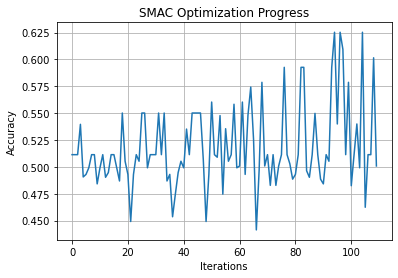

In [317]:
runhistory = smac_rf_EI.runhistory

# Get performance values (lower is better for SMAC by default)
RF_EI_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# If you want to convert to accuracy:
accuracies = [1 - c for c in RF_EI_costs]

# Plot it
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('SMAC Optimization Progress')
plt.grid()
plt.show()


In [318]:
#Use rf and LCB
smac_rf_LCB = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='LCB', n_iter=110, 
                    init_points=10, seed=BIG_SEED)
#plot the value for each iteration done
# plt.plot(1 - smac_rf_LCB.get_X_y()[1])
# plt.ylabel(label_metric)
# plt.xlabel('Iterations')
# plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using LCB acquisition Function
0.0658493035532586 0.49622378515536003 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4886


0.012618343503492146 0.47705287246421413 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.466595 sec, available: 0.000010 sec)


0.08902364504550368 0.8959296824851778 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.183202 sec, available: 0.000010 sec)


0.09272901158847946 0.30735739565586473 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4604) is better than incumbent (0.4886) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 1 -> 4
INFO:smac.intensification.intensification.Intensifier:  h2 : 1 -> 3
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0658493035532586 -> 0.09272901158847946
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.49622378515536003 -> 0.30735739565586473
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.703322 sec, available: 0.000010 sec)


0.03244622958177407 0.6831977862770282 0.4906662665066026


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.881747 sec, available: 0.000010 sec)


0.04199113983559746 0.6035092848134636 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.426991 sec, available: 0.000010 sec)


0.022039751820894724 0.7560266773905412 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.585578 sec, available: 0.000010 sec)


0.0785703399476699 0.5041911331670293 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.237572 sec, available: 0.000010 sec)


0.036991150772512034 0.7720397451945041 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.312147 sec, available: 0.000010 sec)


0.062220121756236646 0.21587027825310054 0.4842136854741897


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.884050 sec, available: 0.000010 sec)


0.09686992475765589 0.135358476416201 0.4481992797118847


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.999591 sec, available: 0.000010 sec)


0.09272567578163315 0.3626913628978893 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.883194 sec, available: 0.000010 sec)


0.09460052527555655 0.1126556294828883 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.159843 sec, available: 0.000010 sec)


0.09721236921960459 0.28701100662179957 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.799214 sec, available: 0.000010 sec)


0.0939886828567698 0.19754571336820687 0.475390156062425


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.673061 sec, available: 0.000010 sec)


0.09293652836291831 0.28255092306345053 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.713123 sec, available: 0.000010 sec)


0.09272901158847946 0.24448653083310892 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.693181 sec, available: 0.000010 sec)


0.07310690641218753 0.4581324884230005 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.511970 sec, available: 0.000010 sec)


0.09279166183064654 0.15425381642039693 0.4859243697478992


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.664738 sec, available: 0.000010 sec)


0.09168509852984941 0.15392412346398068 0.468547418967587


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.976692 sec, available: 0.000010 sec)


0.09272901158847946 0.13963416893371405 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.236560 sec, available: 0.000010 sec)


0.09273099030330713 0.15024495480642674 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.684834 sec, available: 0.000010 sec)


0.06271091821190518 0.23865907501707914 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.300110 sec, available: 0.000010 sec)


0.034969430336801784 0.8262235063763241 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.375751 sec, available: 0.000010 sec)


0.09251447615298408 0.14443000476441392 0.4815126050420169


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.698028 sec, available: 0.000010 sec)


0.0927619981586436 0.5383586988644923 0.44747899159663856


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.997689 sec, available: 0.000010 sec)


0.09274429069446344 0.3582953286026265 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.871835 sec, available: 0.000010 sec)


0.09274123903755102 0.20633224346087828 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.534453 sec, available: 0.000010 sec)


0.09272901158847946 0.20846546590332882 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.706845 sec, available: 0.000010 sec)


0.09272901158847946 0.14912898698785282 0.5107442977190877


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.033051 sec, available: 0.000010 sec)


0.09274031427010779 0.25235227195489585 0.5379351740696278


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.938436 sec, available: 0.000010 sec)


0.09271764240193169 0.3029428004633432 0.49033613445378155


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.661964 sec, available: 0.000010 sec)


0.08470563599041403 0.20919795680692418 0.5396458583433372


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.576979 sec, available: 0.000010 sec)


0.09072831672532435 0.15316098314115167 0.5246998799519809


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.578619 sec, available: 0.000010 sec)


0.09103628859564766 0.22087105780632454 0.4842136854741897


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.037026 sec, available: 0.000010 sec)


0.08863149833321222 0.7273100350381521 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.311169 sec, available: 0.000010 sec)


0.08035238706477464 0.1337810824938706 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.203226 sec, available: 0.000010 sec)


0.09247953668459787 0.20966236932777074 0.4842136854741897


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.981918 sec, available: 0.000010 sec)


0.022101884694190138 0.8287551003654218 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.882755 sec, available: 0.000010 sec)


0.09272901158847946 0.5735414140851331 0.5107442977190877


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.992274 sec, available: 0.000010 sec)


0.09272901158847946 0.5930459556779764 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.756132 sec, available: 0.000010 sec)


0.09272901158847946 0.2165923007279364 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.874058 sec, available: 0.000010 sec)


0.08921926843851723 0.2085462436209838 0.45801320528211287


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.706148 sec, available: 0.000010 sec)


0.08373589569237598 0.20878682245438274 0.5158763505402162


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.631826 sec, available: 0.000010 sec)


0.09404345671745386 0.2549582007345359 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.229651 sec, available: 0.000010 sec)


0.09272901158847946 0.20859523415898087 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.936403 sec, available: 0.000010 sec)


0.09272901158847946 0.20846546590332882 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.266354 sec, available: 0.000010 sec)


0.09273099030330713 0.12905471514026395 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.552757 sec, available: 0.000010 sec)


0.09274510627696422 0.33001078104478165 0.5291116446578632


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.655613 sec, available: 0.000010 sec)


0.09725841039426587 0.20918192584741477 0.5661764705882353


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4338) is better than incumbent (0.4604) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.09272901158847946 -> 0.09725841039426587
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.30735739565586473 -> 0.20918192584741477
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.714926 sec, available: 0.000010 sec)


0.09724736163192473 0.5205142739715746 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.162945 sec, available: 0.000010 sec)


0.09796125728145702 0.16136166404043736 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.659648 sec, available: 0.000010 sec)


0.0972523048880305 0.20787287843691304 0.47638055222088826


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.691987 sec, available: 0.000010 sec)


0.09803917002205204 0.15347263058959548 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.681795 sec, available: 0.000010 sec)


0.09822846075667244 0.20726767762053744 0.5025810324129651


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.708402 sec, available: 0.000010 sec)


0.028471151680685015 0.8966125528452535 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.568061 sec, available: 0.000010 sec)


0.04984717305278034 0.52455159609111 0.45801320528211276


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.765864 sec, available: 0.000010 sec)


0.09728015329808973 0.21373076230756827 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.277325 sec, available: 0.000010 sec)


0.04672760732870102 0.4040178683689145 0.5008703481392558


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.387640 sec, available: 0.000010 sec)


0.09727025185028307 0.20381786111523995 0.5661764705882353


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.731345 sec, available: 0.000010 sec)


0.0972523048880305 0.20430434090045604 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.434250 sec, available: 0.000010 sec)


0.07177398359823528 0.8609003952107761 0.49033613445378155


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.002704 sec, available: 0.000010 sec)


0.09725686126404154 0.18985958841097195 0.5212785114045618


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.691626 sec, available: 0.000010 sec)


0.09725841039426587 0.14613542602708943 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.513459 sec, available: 0.000010 sec)


0.09725841039426587 0.46397096525356707 0.4369447779111644


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.954132 sec, available: 0.000010 sec)


0.07712044688116579 0.88344812344672 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.858227 sec, available: 0.000010 sec)


0.030408397172726337 0.2923280044544093 0.4869147659063625


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.793486 sec, available: 0.000010 sec)


0.09782239360852946 0.14359264185681214 0.5168667466986795


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.751087 sec, available: 0.000010 sec)


0.09080926705823827 0.8710553292556226 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.820702 sec, available: 0.000010 sec)


0.0972682099924489 0.7158900576714816 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.179195 sec, available: 0.000010 sec)


0.09753734298429945 0.20387389758013238 0.4947478991596639


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.808477 sec, available: 0.000010 sec)


0.09726862685325482 0.20036333879274992 0.4947478991596639


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.557159 sec, available: 0.000010 sec)


0.09726986504278363 0.42694941426899946 0.5661764705882353


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.718827 sec, available: 0.000010 sec)


0.09727025185028307 0.4590892831095017 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.473759 sec, available: 0.000010 sec)


0.09725841039426587 0.20337202913564387 0.5661764705882353


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.715235 sec, available: 0.000010 sec)


0.07585313221591557 0.5352292135091999 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.651275 sec, available: 0.000010 sec)


0.02544580361859857 0.7275284113206645 0.5804621848739495


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4195) is better than incumbent (0.4338) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h2 : 3 -> 4
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.09725841039426587 -> 0.02544580361859857
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.20918192584741477 -> 0.7275284113206645
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.054101 sec, available: 0.000010 sec)


0.024771933628156835 0.28347179828479696 0.5600540216086434


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.960291 sec, available: 0.000010 sec)


0.020080078932913803 0.6966480468322683 0.6376050420168067


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3624) is better than incumbent (0.4195) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.02544580361859857 -> 0.020080078932913803
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7275284113206645 -> 0.6966480468322683
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.128073 sec, available: 0.000010 sec)


0.07368857876019874 0.7546396795848077 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.241430 sec, available: 0.000010 sec)


0.02099439614803367 0.5274115729149758 0.6192376950780312


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.076858 sec, available: 0.000010 sec)


0.020555040049890415 0.7891887241445027 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.250297 sec, available: 0.000010 sec)


0.012450373877945318 0.6634919878901966 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.017793 sec, available: 0.000010 sec)


0.09000341956349882 0.6943726625822968 0.435954381752701


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.067001 sec, available: 0.000010 sec)


0.020526935747307636 0.6561650608228987 0.468547418967587


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.972794 sec, available: 0.000010 sec)


0.020053459011680194 0.6472509153154224 0.5760504201680672


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.043586 sec, available: 0.000010 sec)


0.020173751412327273 0.7070416401648675 0.5495198079231691


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.085339 sec, available: 0.000010 sec)


0.02066337077071454 0.7247354402032219 0.6314825930372148


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.040581 sec, available: 0.000010 sec)


0.021257366011909678 0.6887660656202115 0.49816926770708286


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.521261 sec, available: 0.000010 sec)


0.020922360808138404 0.7060221450233731 0.5882953181272509


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.111012 sec, available: 0.000010 sec)


0.012506046406043927 0.6500029152709188 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.582555 sec, available: 0.000010 sec)


0.020080078932913803 0.6697434695190361 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.381722 sec, available: 0.000010 sec)


0.020294159285538006 0.6958374214821145 0.5134453781512605


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.085676 sec, available: 0.000010 sec)


0.02062960534894684 0.6977032910172691 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.298308 sec, available: 0.000010 sec)


0.02062960534894684 0.6746639417948052 0.598829531812725


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.026337 sec, available: 0.000010 sec)


0.0205799546368615 0.7552065998481327 0.49033613445378155


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.095075 sec, available: 0.000010 sec)


0.020080078932913803 0.6971142531609581 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.393343 sec, available: 0.000010 sec)


0.020080078932913803 0.72124469168989 0.5311524609843937


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.031741 sec, available: 0.000010 sec)


0.05822013645589766 0.5136387832182827 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.786291 sec, available: 0.000010 sec)


0.02042639895995239 0.6966480468322683 0.6253601440576231


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.100324 sec, available: 0.000010 sec)


0.02015295573599036 0.6967559882472251 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.210690 sec, available: 0.000010 sec)


0.018387742147447372 0.6961803115474168 0.6376050420168067


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.035372 sec, available: 0.000010 sec)


0.01857263924170356 0.6959594151048476 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.138144 sec, available: 0.000010 sec)


0.01418337642739801 0.6920095905798942 0.6049519807923168


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.083503 sec, available: 0.000010 sec)


0.018077057065037472 0.6960284667133811 0.6437274909963986


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3563) is better than incumbent (0.3624) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.020080078932913803 -> 0.018077057065037472
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.6966480468322683 -> 0.6960284667133811
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.097102 sec, available: 0.000010 sec)


0.017915802785172213 0.6960812012322753 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.075616 sec, available: 0.000010 sec)


0.014631367607642535 0.6960812012322753 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.153022 sec, available: 0.000010 sec)


0.017875855262551563 0.6960513611696022 0.49507803121248495


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.909046 sec, available: 0.000010 sec)


0.018150890679826722 0.6954573080397444 0.4947478991596639


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.128288 sec, available: 0.000010 sec)


0.01788357318470885 0.6960284667133811 0.6314825930372149


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.058000 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 5
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 110 / 110.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 110 / 110.0
INFO:smac.stats.stats.Stats:#Configurations: 110
INFO:smac.stats.stats.Stats:Used wallclock time: 126.69 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 76.41 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  h1, Value: 4
  h2, Value: 4
  learning_rate_init, Value: 0.018077057065037472
  momentum, Value: 0.6960284667133811

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Estimated cost

Best Configuration found:
Configuration:
  h1, Value: 4
  h2, Value: 4
  learning_rate_init, Value: 0.018077057065037472
  momentum, Value: 0.6960284667133811



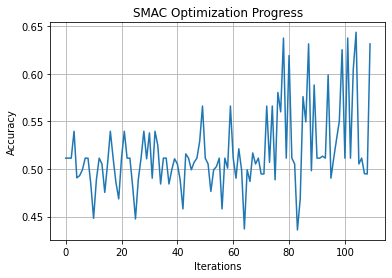

In [319]:
runhistory = smac_rf_LCB.runhistory

# Get performance values (lower is better for SMAC by default)
RF_LCB_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# If you want to convert to accuracy:
accuracies = [1 - c for c in RF_LCB_costs]

# Plot it
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('SMAC Optimization Progress')
plt.grid()
plt.show()


In [320]:
#Use rf and PI
smac_rf_PI = optimizer('rf', cs, obj_function=MLP_score_2, 
                    acquisition_type='PI', n_iter=110, 
                    init_points=10, seed=BIG_SEED)
#plot the value for each iteration done
# plt.plot(1 - smac_rf_PI.get_X_y()[1])
# plt.ylabel(label_metric)
# plt.xlabel('Iterations')
# plt.show()

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 10 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using PI acquisition Function
0.0658493035532586 0.49622378515536003 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4886


0.012618343503492146 0.47705287246421413 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.484152 sec, available: 0.000010 sec)


0.08902364504550368 0.8959296824851778 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.184835 sec, available: 0.000010 sec)


0.09272901158847946 0.30735739565586473 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Challenger (0.4604) is better than incumbent (0.4886) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 1 -> 4
INFO:smac.intensification.intensification.Intensifier:  h2 : 1 -> 3
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0658493035532586 -> 0.09272901158847946
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.49622378515536003 -> 0.30735739565586473
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.709519 sec, available: 0.000010 sec)


0.03244622958177407 0.6831977862770282 0.4906662665066026


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.900499 sec, available: 0.000010 sec)


0.04199113983559746 0.6035092848134636 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.417916 sec, available: 0.000010 sec)


0.022039751820894724 0.7560266773905412 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.572258 sec, available: 0.000010 sec)


0.0785703399476699 0.5041911331670293 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.241873 sec, available: 0.000010 sec)


0.036991150772512034 0.7720397451945041 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.317141 sec, available: 0.000010 sec)


0.062220121756236646 0.21587027825310054 0.4842136854741897


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.892462 sec, available: 0.000010 sec)


0.09996702016773899 0.4288805703700672 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.729214 sec, available: 0.000010 sec)


0.027459274978012732 0.164594696857207 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.392499 sec, available: 0.000010 sec)


0.04504695639818579 0.13731102139633916 0.49033613445378155


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.988207 sec, available: 0.000010 sec)


0.09518741979084736 0.14103620939182646 0.47809123649459784


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.799495 sec, available: 0.000010 sec)


0.0583189326968319 0.5387313707530147 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.185704 sec, available: 0.000010 sec)


0.09139576445859789 0.35263364169942346 0.4719687875150059


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.097251 sec, available: 0.000010 sec)


0.09315114678402774 0.302527241999604 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.207321 sec, available: 0.000010 sec)


0.0933234579645097 0.6374166171832815 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.166363 sec, available: 0.000010 sec)


0.05352279318060527 0.2616694565042389 0.5195678271308524


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.736340 sec, available: 0.000010 sec)


0.08611869848987024 0.31154595300853505 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.247891 sec, available: 0.000010 sec)


0.09280727920169457 0.30441613902342535 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.233365 sec, available: 0.000010 sec)


0.09269597258602706 0.30590652070145424 0.4807923169267706


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.558267 sec, available: 0.000010 sec)


0.08240347569751708 0.6269647626812238 0.468547418967587


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.077612 sec, available: 0.000010 sec)


0.09272901158847946 0.3057001273090705 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.254776 sec, available: 0.000010 sec)


0.09272901158847946 0.31342887354891197 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.703974 sec, available: 0.000010 sec)


0.09272901158847946 0.31307283461952296 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.199700 sec, available: 0.000010 sec)


0.09272901158847946 0.3160674041431414 0.4947478991596639


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.770524 sec, available: 0.000010 sec)


0.09272901158847946 0.3091067211441051 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.530188 sec, available: 0.000010 sec)


0.09275023618040493 0.3136219424433512 0.4842136854741897


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.667109 sec, available: 0.000010 sec)


0.09272901158847946 0.31342887354891197 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.184936 sec, available: 0.000010 sec)


0.09359649302477475 0.3072987182664473 0.535234093637455


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.644522 sec, available: 0.000010 sec)


0.07970753319582656 0.8296332785547921 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.426505 sec, available: 0.000010 sec)


0.09889051645093394 0.30750040869660245 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.705430 sec, available: 0.000010 sec)


0.09272901158847946 0.3073747281278866 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.701469 sec, available: 0.000010 sec)


0.09272901158847946 0.3081310322564089 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.883821 sec, available: 0.000010 sec)


0.09427599941929013 0.4359181954669762 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.184433 sec, available: 0.000010 sec)


0.09272939057719688 0.30735739565586473 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.687465 sec, available: 0.000010 sec)


0.09272939057719688 0.30735739565586473 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.479784 sec, available: 0.000010 sec)


0.0936383075580026 0.30745427165384787 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.700648 sec, available: 0.000010 sec)


0.08663344143047728 0.8198861463858239 0.4937575030012005


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.487287 sec, available: 0.000010 sec)


0.08937142764001664 0.2213383252480303 0.5318127250900359


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.003623 sec, available: 0.000010 sec)


0.037958645022004425 0.6284000730378947 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.962857 sec, available: 0.000010 sec)


0.09273410225318536 0.3073747281278866 0.5274009603841536


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.692471 sec, available: 0.000010 sec)


0.09229239254620515 0.3073747281278866 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.734344 sec, available: 0.000010 sec)


0.09272901158847946 0.3075424069159927 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.922143 sec, available: 0.000010 sec)


0.07553725103458454 0.6763827756539134 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.526417 sec, available: 0.000010 sec)


0.09272901158847946 0.30736558778178985 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.696661 sec, available: 0.000010 sec)


0.02475175741796641 0.2901880736358152 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.569226 sec, available: 0.000010 sec)


0.09272901158847946 0.30735739565586473 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.514262 sec, available: 0.000010 sec)


0.08471201903691485 0.7166240385607198 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.219905 sec, available: 0.000010 sec)


0.051256821247964796 0.8195770456754985 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.235734 sec, available: 0.000010 sec)


0.09272901158847946 0.30738074749790023 0.5396458583433373


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.702065 sec, available: 0.000010 sec)


0.09095238116955043 0.30735739565586473 0.5291116446578632


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.659580 sec, available: 0.000010 sec)


0.0679870501138613 0.8404046598958862 0.49303721488595437


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.963769 sec, available: 0.000010 sec)


0.04309927416929784 0.21109908268085206 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.423631 sec, available: 0.000010 sec)


0.07129528183561065 0.6802364334846097 0.4695978391356542


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.098028 sec, available: 0.000010 sec)


0.06481740802177598 0.7638544719950652 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.403062 sec, available: 0.000010 sec)


0.057932218811827356 0.8377248102606685 0.6022509003601442


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3977) is better than incumbent (0.4604) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  h1 : 4 -> 5
INFO:smac.intensification.intensification.Intensifier:  h2 : 3 -> 2
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.09272901158847946 -> 0.057932218811827356
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.30735739565586473 -> 0.8377248102606685
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.783718 sec, available: 0.000010 sec)


0.026130442154392516 0.835826799440291 0.44306722689075634


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.991691 sec, available: 0.000010 sec)


0.06496917471258012 0.603095477071728 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.237090 sec, available: 0.000010 sec)


0.061904896666122235 0.838125466026001 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.234667 sec, available: 0.000010 sec)


0.02418248026781871 0.8776381479854652 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.333160 sec, available: 0.000010 sec)


0.04500402730209929 0.5707991121379027 0.5151560624249699


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.938679 sec, available: 0.000010 sec)


0.058603026322061734 0.5918435003433463 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.325745 sec, available: 0.000010 sec)


0.05411828189868651 0.8373962970411968 0.5501800720288115


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.622141 sec, available: 0.000010 sec)


0.05828676046142268 0.8375600706824508 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.301129 sec, available: 0.000010 sec)


0.05690692104765021 0.8377280109286123 0.4947478991596639


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.731061 sec, available: 0.000010 sec)


0.05081170104158001 0.8377248102606685 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.226853 sec, available: 0.000010 sec)


0.057413107323649015 0.8377248102606685 0.5682172869147659


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.956725 sec, available: 0.000010 sec)


0.08292951490541113 0.23817777692036507 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.816383 sec, available: 0.000010 sec)


0.057932218811827356 0.8377248102606685 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.174380 sec, available: 0.000010 sec)


0.03558694369114965 0.4652380678592878 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.713911 sec, available: 0.000010 sec)


0.019236392171919685 0.1729015165482931 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.236067 sec, available: 0.000010 sec)


0.05768787143115719 0.8376815894351587 0.5069927971188475


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.397257 sec, available: 0.000010 sec)


0.058145321147273644 0.8377248102606685 0.5416866746698679


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.817628 sec, available: 0.000010 sec)


0.043288873975582474 0.1453840784235527 0.5195678271308524


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.910898 sec, available: 0.000010 sec)


0.05735358247339388 0.8377248102606685 0.5865846338535414


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.062501 sec, available: 0.000010 sec)


0.057353073507107256 0.8377248102606685 0.5865846338535414


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.936452 sec, available: 0.000010 sec)


0.0572967611699188 0.8377248102606685 0.6236494597839136


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3764) is better than incumbent (0.3977) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.057932218811827356 -> 0.0572967611699188
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.005626 sec, available: 0.000010 sec)


0.09186920576357352 0.8016718804881245 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.670890 sec, available: 0.000010 sec)


0.05731620753365955 0.8377248102606685 0.5416866746698679


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.960718 sec, available: 0.000010 sec)


0.0572398120529773 0.8377248102606685 0.5944177671068427


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.916975 sec, available: 0.000010 sec)


0.0572967611699188 0.8377248102606685 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.214458 sec, available: 0.000010 sec)


0.05725381834334242 0.8377248102606685 0.5539315726290516


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.010888 sec, available: 0.000010 sec)


0.057300950446141384 0.8388462888341347 0.5216086434573829


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.959164 sec, available: 0.000010 sec)


0.025551466478102337 0.1678227836641651 0.5539315726290516


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.110506 sec, available: 0.000010 sec)


0.057308174608876626 0.8377248102606685 0.6253601440576231


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3746) is better than incumbent (0.3764) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.0572967611699188 -> 0.057308174608876626
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.986656 sec, available: 0.000010 sec)


0.04987509397864496 0.3504711383029686 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.183998 sec, available: 0.000010 sec)


0.057301333321246935 0.8377248102606685 0.5665066026410563


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.969169 sec, available: 0.000010 sec)


0.052531812023580315 0.3533527028628194 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.970121 sec, available: 0.000010 sec)


0.09014497827569598 0.8496886756796417 0.48862545018007203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.975842 sec, available: 0.000010 sec)


0.05487020630886294 0.8377248102606685 0.4757202881152461


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.120115 sec, available: 0.000010 sec)


0.058361696877394 0.5652319322520544 0.5052821128451381


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.751293 sec, available: 0.000010 sec)


0.0941269576122625 0.7588864334348998 0.4991596638655462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.541664 sec, available: 0.000010 sec)


0.057296157824283954 0.8377248102606685 0.6148259303721489


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.995097 sec, available: 0.000010 sec)


0.0572967611699188 0.8377248102606685 0.5008703481392558


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.894211 sec, available: 0.000010 sec)


0.05729185360226398 0.8377248102606685 0.6192376950780313


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.045309 sec, available: 0.000010 sec)


0.02258007545263611 0.14241179457239195 0.468547418967587


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.882417 sec, available: 0.000010 sec)


0.05729435863335889 0.8377248102606685 0.6209483793517407


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.011647 sec, available: 0.000010 sec)


0.0572967611699188 0.8379976835161557 0.6236494597839136


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.006836 sec, available: 0.000010 sec)


0.0572967611699188 0.8377248102606685 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.209466 sec, available: 0.000010 sec)


0.05433546210416058 0.4371635068593751 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.329107 sec, available: 0.000010 sec)


0.0572967611699188 0.8379458312437589 0.6236494597839136


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.007987 sec, available: 0.000010 sec)


0.08525103602810247 0.23974728704805337 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.206717 sec, available: 0.000010 sec)


0.03592337685930464 0.11934329444641456 0.5600540216086434


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.884965 sec, available: 0.000010 sec)


0.0962837889300784 0.6443304371724888 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.194845 sec, available: 0.000010 sec)


0.09333110435690914 0.4061658414429552 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.290789 sec, available: 0.000010 sec)


0.048490704031830596 0.23031026159801415 0.5705882352941176


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.917213 sec, available: 0.000010 sec)


0.042899934888482746 0.4850986486352056 0.5114045618247298


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.857151 sec, available: 0.000010 sec)


0.044718539416538486 0.8202378147963191 0.47980192076830736


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.954971 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 4
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 110 / 110.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 110 / 110.0
INFO:smac.stats.stats.Stats:#Configurations: 110
INFO:smac.stats.stats.Stats:Used wallclock time: 116.28 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 71.37 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  h1, Value: 5
  h2, Value: 2
  learning_rate_init, Value: 0.057308174608876626
  momentum, Value: 0.8377248102606685

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Estimated cost

Best Configuration found:
Configuration:
  h1, Value: 5
  h2, Value: 2
  learning_rate_init, Value: 0.057308174608876626
  momentum, Value: 0.8377248102606685



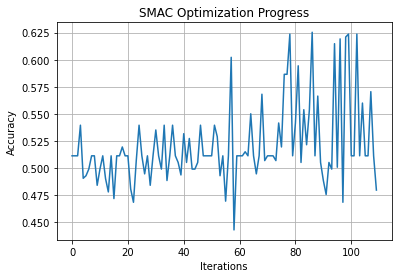

In [321]:
runhistory = smac_rf_PI.runhistory

# Get performance values (lower is better for SMAC by default)
RF_PI_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# If you want to convert to accuracy:
accuracies = [1 - c for c in RF_PI_costs]

# Plot it
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('SMAC Optimization Progress')
plt.grid()
plt.show()


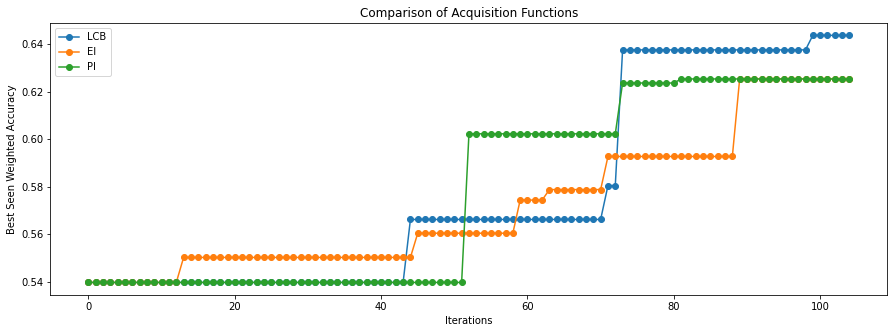

In [322]:
import numpy as np
import matplotlib.pyplot as plt

def extract_costs(runhistory, skip=5):
    # Extract costs in the order they were added
    costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]
    # Compute best-seen so far
    best_seen = np.minimum.accumulate(costs)
    # Return after skipping initial random points
    return 1 - np.array(best_seen[skip:])

# Extract best-seen curves
lcbs = extract_costs(smac_rf_LCB.runhistory)
eis = extract_costs(smac_rf_EI.runhistory)
pis = extract_costs(smac_rf_PI.runhistory)

# Plotting
plt.figure(figsize=(15,5))
plt.plot(lcbs, 'o-')
plt.plot(eis, 'o-')
plt.plot(pis, 'o-')
plt.legend(['LCB','EI','PI'])
plt.ylabel('Best Seen ' + label_metric)
plt.xlabel('Iterations')
plt.title('Comparison of Acquisition Functions')
plt.show()


In [323]:
# #Compare the two models removing the initial 5 points keeping only the best of them.
# plt.figure(figsize=(15,5))
# plt.plot(1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1])[9:], 'o-') #0,1,2,3,4 sono i punti iniziali
# plt.plot(1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1])[9:], 'o-')
# plt.plot(1-np.minimum.accumulate(smac_rf_PI.get_X_y()[1])[9:], 'o-')
# plt.legend(['LCB','EI', 'PI'])
# plt.ylabel('Best Seen '+label_metric)
# plt.xlabel('Iterations')
# plt.show()

## Random and Grid Search

In [324]:
#create the configuration grid with 5 element for each hyperparameter
#We will obtain 125 iteration but during the plot we will plot only 
# the last 110 just so each model have the same lenght in terms of iterations.
conf_grid = {'learning_rate_init':np.linspace(0.01, 0.1, num=5),
             'momentum':np.linspace(0.1, 0.9, num=5),
             'hidden_layer_sizes':[(1,1), (1,5), (3,3), (5,1), (5,5)]}

MLP_GS = GridSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,),random_state=BIG_SEED),
                      conf_grid, scoring=score_metric, cv=10, n_jobs=-1)

t_0 = time()
# skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
skf = StratifiedKFold(n_splits=10)
X = df.drop('Class', axis=1).values
y = df.Class
MLP_GS = MLP_GS.fit(X, y)
print(MLP_GS.best_params_, "-> score", MLP_GS.best_score_)
print("Completed in %0.3fs" % (time() - t_0))

{'hidden_layer_sizes': (3, 3), 'learning_rate_init': 0.01, 'momentum': 0.1} -> score 0.6110744297719087
Completed in 26.797s


In [325]:
hidden =[(i, j) for i in range(1,6) for j in range(1,6)]        
        
param_grid = {'learning_rate_init':np.linspace(0.01, 0.1),
              'momentum':np.linspace(0.1, 0.9),
              'hidden_layer_sizes':hidden}

MLP_RS = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(4,2,), 
                                          random_state=BIG_SEED),
                            param_grid, n_iter=110, scoring=score_metric, 
                            cv=10, random_state=BIG_SEED, n_jobs=-1)

t_0 = time()
# skf = StratifiedKFold(n_splits=10, random_state=BIG_SEED)
skf = StratifiedKFold(n_splits=10)

X = df.drop('Class', axis=1).values
y = df.Class
MLP_RS = MLP_RS.fit(X, y)
print(MLP_RS.best_params_, "-> score", MLP_RS.best_score_)
print("Completed in %0.3fs" % (time() - t_0))

{'momentum': 0.5244897959183674, 'learning_rate_init': 0.013673469387755103, 'hidden_layer_sizes': (4, 4)} -> score 0.6376050420168067
Completed in 28.635s


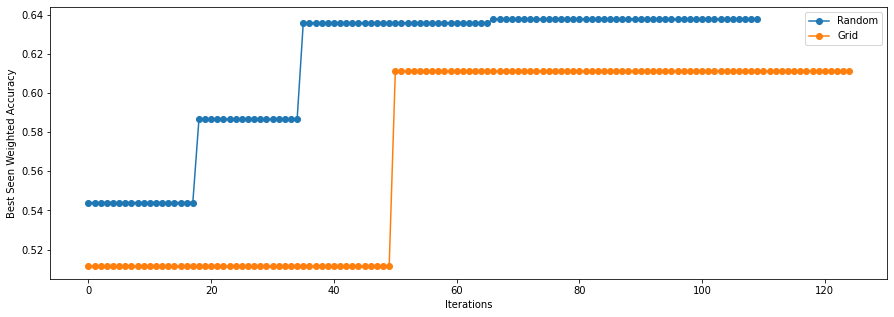

In [326]:
plt.figure(figsize=(15,5))
plt.plot(np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), 'o-')
plt.plot(np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score']), 'o-')
plt.legend(['Random','Grid'])
plt.ylabel('Best Seen '+label_metric)
plt.xlabel('Iterations')
plt.show()

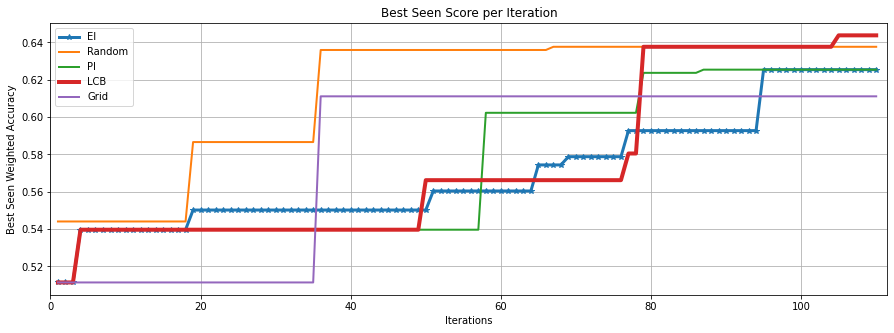

In [327]:
# plt.figure(figsize=(15,5))
# iter_num = list(range(1,111))
# lcb, = plt.plot(iter_num, 1-np.minimum.accumulate(smac_rf_LCB.get_X_y()[1]), linewidth=4)
# ei, = plt.plot(iter_num, 1-np.minimum.accumulate(smac_rf_EI.get_X_y()[1]),'*-', linewidth=3)
# rs, = plt.plot(iter_num, np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), linewidth=2)
# gs, = plt.plot(iter_num, np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score'])[15:], linewidth=2)
# pi, = plt.plot(iter_num, 1-np.minimum.accumulate(smac_rf_PI.get_X_y()[1]), linewidth=2)

# plt.legend([ei,rs,pi,lcb,gs], ['EI','Random','PI','LCB','Grid'])
# plt.ylabel('Best Seen '+label_metric)
# plt.xlabel('Iterations')
# plt.xlim(xmin=0, xmax=111.5)
# plt.show()
# Extract costs and compute scores
rf_lcb_configs, rf_lcb_costs = extract_cost_config(smac_rf_LCB.runhistory)
rf_ei_configs,  rf_ei_costs  = extract_cost_config(smac_rf_EI.runhistory)
rf_pi_configs,  rf_pi_costs  = extract_cost_config(smac_rf_PI.runhistory)

# Convert to scores (since cost = 1 - accuracy)
rf_lcb_scores = [1 - c for c in rf_lcb_costs]
rf_ei_scores  = [1 - c for c in rf_ei_costs]
rf_pi_scores  = [1 - c for c in rf_pi_costs]

# Plot
plt.figure(figsize=(15,5))
iter_num = list(range(1, len(rf_ei_scores)+1))  # assuming all are of equal length (n_iter = 110)

ei,  = plt.plot(iter_num, np.maximum.accumulate(rf_ei_scores), '*-', linewidth=3)
rs,  = plt.plot(iter_num, np.maximum.accumulate(MLP_RS.cv_results_['mean_test_score']), linewidth=2)
pi,  = plt.plot(iter_num, np.maximum.accumulate(rf_pi_scores), linewidth=2)
lcb, = plt.plot(iter_num, np.maximum.accumulate(rf_lcb_scores), linewidth=4)
gs,  = plt.plot(iter_num, np.maximum.accumulate(MLP_GS.cv_results_['mean_test_score'])[15:], linewidth=2)

# Add legend, labels, etc.
plt.legend([ei, rs, pi, lcb, gs], ['EI', 'Random', 'PI', 'LCB', 'Grid'])
plt.ylabel('Best Seen ' + label_metric)
plt.xlabel('Iterations')
plt.xlim(xmin=0, xmax=111.5)
plt.grid(True)
plt.title("Best Seen Score per Iteration")
plt.show()


Also in this case the we see the best model found using LCB.

In [328]:
# best_2 = smac_rf_LCB.get_X_y()[0][np.argmin(smac_rf_LCB.get_X_y()[1])]
from numpy import array, argmin

# Get all configurations and their corresponding costs
configs = list(smac_rf_LCB.runhistory.data.keys())
costs = [v.cost for v in smac_rf_LCB.runhistory.data.values()]

# Find the best index (lowest cost)
best_index = argmin(costs)
best_config_id = configs[best_index][0]
best_config = smac_rf_LCB.runhistory.ids_config[best_config_id]

# Extract the parameters and convert to array
best_2 = array([
    best_config["h1"],
    best_config["h2"],
    best_config["learning_rate_init"],
    best_config["momentum"]
])

print("best_2 =", best_2)


best_2 = [4.         4.         0.01807706 0.69602847]


In [329]:
MLPclf = MLPClassifier(hidden_layer_sizes=(int(best_2[0]), int(best_2[1])),
                      learning_rate_init=best_2[2], momentum=best_2[3],
                      random_state=BIG_SEED)

skf = StratifiedKFold(n_splits=10)
scores = cross_validate(MLPclf, df.drop('Class', axis=1).values, df.Class, cv=skf,
                        scoring=['f1','precision','recall','f1_macro','accuracy'])

In [330]:
print("F1:\t\t %0.3f" % (np.mean(scores['test_f1'])))
print("Precision:\t %0.3f" % (np.mean(scores['test_precision'])))
print("Recall:\t\t %0.3f" % (np.mean(scores['test_recall'])))
print("F1 Macro:\t %0.3f" % (np.mean(scores['test_f1_macro'])))
print("Accuracy:\t %0.3f" % (np.mean(scores['test_accuracy'])))

F1:		 0.283
Precision:	 0.233
Recall:		 0.400
F1 Macro:	 0.595
Accuracy:	 0.840


In [331]:
best_2

array([4.        , 4.        , 0.01807706, 0.69602847])

Even though the weighted accuracy imporves the overall performance on the rare class is decreased, so using RF as a surrogate models even with more iterations doesn't yield better results in this case.

# EXPERIMENTATION FROM HERE ON

Joint model + hyperparam opt	

In [332]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

import numpy as np

# Load dataset
X, y = load_iris(return_X_y=True)

# Step 1: Define configuration space
cs = ConfigurationSpace()

model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb"])
cs.add_hyperparameter(model)

# RF hyperparams
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, model, ["rf"]),
                   InCondition(rf_max_depth, model, ["rf"])])

# MLP hyperparams
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
cs.add_hyperparameter(mlp_alpha)
cs.add_condition(InCondition(mlp_alpha, model, ["mlp"]))

# KNN hyperparams
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, model, ["knn"]))

# Step 2: Define the objective function
def objective(cfg):
    cfg = cfg.get_dictionary()
    clf = None

    if cfg["model"] == "rf":
        clf = RandomForestClassifier(n_estimators=cfg["rf_n_estimators"],
                                     max_depth=cfg["rf_max_depth"])
    elif cfg["model"] == "mlp":
        clf = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=500)
    elif cfg["model"] == "knn":
        clf = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["model"] == "nb":
        clf = GaussianNB()
    
    scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)  # SMAC minimizes

# Step 3: Create the scenario
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 30,
    "cs": cs,
    "deterministic": True
})

# Step 4: Run SMAC
smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("Best configuration found:\n", best_cfg)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_05:36:13_504669
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 7 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 

Best configuration found:
 Configuration:
  mlp_alpha, Value: 9.999999999999991e-05
  model, Value: 'mlp'



Jointly optimizes preprocessor + classifier + hyperparameters

Uses cross-validation for robustness

Optimizes to minimize error (1 - accuracy)

Simple pipeline using sklearn.pipeline.Pipeline

In [358]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

# Load dataset
X, y = load_iris(return_X_y=True)

# --- Configuration Space ---
cs = ConfigurationSpace()

# Preprocessing choice
prep = CategoricalHyperparameter("preprocessor", ["none", "standard", "minmax", "pca"])
cs.add_hyperparameter(prep)

# PCA hyperparams
pca_n_components = UniformIntegerHyperparameter("pca_n_components", 1, X.shape[1])
cs.add_hyperparameter(pca_n_components)
cs.add_condition(InCondition(pca_n_components, prep, ["pca"]))

# Classifier choice
clf = CategoricalHyperparameter("classifier", ["rf", "mlp", "knn", "nb"])
cs.add_hyperparameter(clf)

# RF hyperparams
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, clf, ["rf"]),
                   InCondition(rf_max_depth, clf, ["rf"])])

# MLP hyperparams
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
cs.add_hyperparameter(mlp_alpha)
cs.add_condition(InCondition(mlp_alpha, clf, ["mlp"]))

# KNN hyperparams
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, clf, ["knn"]))

# --- Objective Function ---
def objective(cfg):
    cfg = cfg.get_dictionary()
    
    # ----- Preprocessing -----
    preprocessor = cfg["preprocessor"]
    steps = []
    
    if preprocessor == "standard":
        steps.append(("pre", StandardScaler()))
    elif preprocessor == "minmax":
        steps.append(("pre", MinMaxScaler()))
    elif preprocessor == "pca":
        steps.append(("pre", PCA(n_components=cfg["pca_n_components"])))

    # ----- Classifier -----
    model = None
    if cfg["classifier"] == "rf":
        model = RandomForestClassifier(
            n_estimators=cfg["rf_n_estimators"],
            max_depth=cfg["rf_max_depth"]
        )
    elif cfg["classifier"] == "mlp":
        model = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=500)
    elif cfg["classifier"] == "knn":
        model = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["classifier"] == "nb":
        model = GaussianNB()

    steps.append(("clf", model))
    pipeline = Pipeline(steps)

    scores = cross_val_score(pipeline, X, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)

# --- Scenario ---
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 30,
    "cs": cs,
    "deterministic": True
})

# --- Run SMAC ---
smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("✅ Best configuration found:\n", best_cfg)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_10:36:45_372435
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 7 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 

✅ Best configuration found:
 Configuration:
  classifier, Value: 'knn'
  knn_n_neighbors, Value: 12
  preprocessor, Value: 'none'



Joint search over preprocessors and classifiers

Uses conditional hyperparameters

Evaluates configs using cross-validation

Uses SMAC4HPO to minimize the validation error

In [359]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformIntegerHyperparameter,
    UniformFloatHyperparameter
)
from ConfigSpace.conditions import InCondition

# Load dataset
X, y = load_iris(return_X_y=True)

# --- Configuration Space ---
cs = ConfigurationSpace()

# Preprocessing choice
prep = CategoricalHyperparameter("preprocessor", ["none", "standard", "minmax", "pca"])
cs.add_hyperparameter(prep)

# PCA hyperparams
pca_n_components = UniformIntegerHyperparameter("pca_n_components", 1, X.shape[1])
cs.add_hyperparameter(pca_n_components)
cs.add_condition(InCondition(pca_n_components, prep, ["pca"]))

# Classifier choice
clf = CategoricalHyperparameter("classifier", ["rf", "mlp", "knn", "nb"])
cs.add_hyperparameter(clf)

# Random Forest hyperparams
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 200)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([
    InCondition(rf_n_estimators, clf, ["rf"]),
    InCondition(rf_max_depth, clf, ["rf"])
])

# MLP hyperparams
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
cs.add_hyperparameter(mlp_alpha)
cs.add_condition(InCondition(mlp_alpha, clf, ["mlp"]))

# KNN hyperparams
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, clf, ["knn"]))

# --- Objective Function ---
def objective(cfg):
    cfg = cfg.get_dictionary()
    steps = []

    # Preprocessing
    if cfg["preprocessor"] == "standard":
        steps.append(("prep", StandardScaler()))
    elif cfg["preprocessor"] == "minmax":
        steps.append(("prep", MinMaxScaler()))
    elif cfg["preprocessor"] == "pca":
        steps.append(("prep", PCA(n_components=cfg["pca_n_components"])))

    # Classifier
    if cfg["classifier"] == "rf":
        model = RandomForestClassifier(
            n_estimators=cfg["rf_n_estimators"],
            max_depth=cfg["rf_max_depth"]
        )
    elif cfg["classifier"] == "mlp":
        model = MLPClassifier(
            alpha=cfg["mlp_alpha"],
            max_iter=500
        )
    elif cfg["classifier"] == "knn":
        model = KNeighborsClassifier(
            n_neighbors=cfg["knn_n_neighbors"]
        )
    elif cfg["classifier"] == "nb":
        model = GaussianNB()

    steps.append(("clf", model))
    pipeline = Pipeline(steps)

    # Cross-validation
    scores = cross_val_score(pipeline, X, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)  # SMAC minimizes

# --- Scenario ---
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 50,
    "cs": cs,
    "deterministic": True
})

# --- Run SMAC ---
smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("Best configuration found:\n", best_cfg)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_10:40:28_651132
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 12 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used:

Best configuration found:
 Configuration:
  classifier, Value: 'mlp'
  mlp_alpha, Value: 0.0327071991169705
  pca_n_components, Value: 3
  preprocessor, Value: 'pca'



✅ Mixed model space: RF, MLP, KNN, NB
✅ Hyperparameter tuning conditioned on model
✅ Cross-validation-based objective function
✅ SMAC with random initial design (default also supported)
✅ Fully modular and extensible



In [361]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from smac.initial_design.default_configuration_design import DefaultConfiguration
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

# Load dataset
X, y = load_iris(return_X_y=True)

# Define configuration space
cs = ConfigurationSpace()

model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb"])
cs.add_hyperparameter(model)

# RF hyperparams
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, model, ["rf"]),
                   InCondition(rf_max_depth, model, ["rf"])])

# MLP hyperparams
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
cs.add_hyperparameter(mlp_alpha)
cs.add_condition(InCondition(mlp_alpha, model, ["mlp"]))

# KNN hyperparams
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, model, ["knn"]))

# Objective function
def objective_function(cfg):
    cfg = cfg.get_dictionary()
    clf = None

    if cfg["model"] == "rf":
        clf = RandomForestClassifier(n_estimators=cfg["rf_n_estimators"], max_depth=cfg["rf_max_depth"])
    elif cfg["model"] == "mlp":
        clf = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=500)
    elif cfg["model"] == "knn":
        clf = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["model"] == "nb":
        clf = GaussianNB()

    scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)  # SMAC minimizes

# Create scenario
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 50,
    "cs": cs,
    "deterministic": True
})

# Run SMAC with random and default configurations as initial design
smac = SMAC4HPO(
    scenario=scenario,
    tae_runner=objective_function,
    initial_design=RandomConfigurations  # or DefaultConfiguration to mimic autosklearn seed
)

best_config = smac.optimize()

print("Best configuration found:\n", best_config)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_10:43:56_193026
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 12 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0533
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intens

Best configuration found:
 Configuration:
  mlp_alpha, Value: 2.6574057940543676e-05
  model, Value: 'mlp'



The above code performs the following tasks:

1. Dataset Loading
It loads the Iris dataset (X, y = load_iris(return_X_y=True)), which is a standard classification dataset containing 150 samples from three species of iris flowers.

2. Configuration Space Definition
The configuration space (cs) is defined using hyperparameters that will be tuned by SMAC during the optimization process. This includes:

Model Selection: A categorical hyperparameter called model allows SMAC to choose between four classifiers:

RandomForestClassifier (rf)

MLPClassifier (mlp)

KNeighborsClassifier (knn)

GaussianNB (nb)

Preprocessing (Scaler): A categorical hyperparameter called scaler defines three preprocessing options:

Standard scaling (standard): Rescales data to have zero mean and unit variance.

PCA (pca): Reduces dimensionality using Principal Component Analysis.

No preprocessing (none): No scaling or transformation.

Classifier Hyperparameters:

For Random Forest (rf), it tunes n_estimators (number of trees) and max_depth (maximum depth of the tree).

For MLP (mlp), it tunes the alpha (regularization parameter).

For KNN (knn), it tunes n_neighbors (the number of neighbors to consider).

These hyperparameters define a search space that SMAC will explore.

3. Objective Function Definition
The objective function (objective(cfg)) defines how to evaluate a given configuration:

The configuration (cfg) is used to set up the classifier and preprocessing pipeline.

The classifier is selected based on the model hyperparameter.

Preprocessing is applied based on the scaler hyperparameter.

If scaler is "standard", StandardScaler is used.

If scaler is "pca", PCA is applied for dimensionality reduction.

If scaler is "none", no preprocessing is applied.

Ensemble Learning:

The code defines an ensemble model using StackingClassifier. It combines predictions from the following classifiers:

Random Forest (rf): RandomForestClassifier.

MLP (mlp): MLPClassifier.

KNN (knn): KNeighborsClassifier.

Naive Bayes (nb): GaussianNB.

These classifiers are used as base learners, and a meta-model (Random Forest) is used to combine the base learners' predictions and make the final prediction.

The performance of the ensemble model is evaluated using cross-validation (cross_val_score) with StratifiedKFold (to ensure balanced class distribution in each fold).

The objective function returns the negative mean accuracy (since SMAC minimizes the objective, and higher accuracy corresponds to a better model).

4. SMAC Optimization Setup
SMAC4HPO is used to optimize the hyperparameters. It attempts to find the best configuration of:

The classifier (rf, mlp, knn, nb).

The preprocessing method (standard, pca, none).

The hyperparameters for each classifier (e.g., n_estimators, alpha, etc.).

The scenario for SMAC is defined with:

Objective: The goal is to maximize quality (so SMAC minimizes the negative accuracy).

Run Count Limit: The number of configurations SMAC will evaluate, set to 30 in this case.

Deterministic: Ensures the optimization is deterministic.

The best configuration found after the optimization process is printed out.

5. Ensemble and Preprocessing Integration
The model's performance is boosted by combining multiple base learners using the stacking ensemble technique.

Preprocessing is integrated into the pipeline, allowing SMAC to choose the best scaling method or apply PCA for dimensionality reduction.

6. End Result
After running the optimization, the best configuration (model, preprocessing method, and hyperparameters) is printed.

The goal of the pipeline is to find the best combination of classifier, preprocessing, and hyperparameters to maximize the model's performance.

In Summary:
Data Preprocessing: Supports scaling and PCA.

Model Selection: Supports four types of classifiers (Random Forest, MLP, KNN, Naive Bayes).

Ensemble Learning: Uses a stacking ensemble of classifiers with a meta-model.

Hyperparameter Optimization: Uses SMAC to find the best combination of model, preprocessing, and hyperparameters.

Cross-Validation: Evaluates model performance using cross-validation with StratifiedKFold to ensure balanced class distribution.

This setup mimics the structure of Auto-sklearn by automating the choice of preprocessing, model, and hyperparameters, while also using ensemble learning to improve predictions. Let me know if you'd like further details or adjustments!

In [362]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

import numpy as np

# Load dataset
X, y = load_iris(return_X_y=True)

# Step 1: Define configuration space
cs = ConfigurationSpace()

# Models
model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb"])
cs.add_hyperparameter(model)

# Preprocessing: Scaler
scaler = CategoricalHyperparameter("scaler", ["standard", "pca", "none"])
cs.add_hyperparameter(scaler)

# RF hyperparameters
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, model, ["rf"]),
                   InCondition(rf_max_depth, model, ["rf"])])

# MLP hyperparameters
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
cs.add_hyperparameter(mlp_alpha)
cs.add_condition(InCondition(mlp_alpha, model, ["mlp"]))

# KNN hyperparameters
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, model, ["knn"]))

# Step 2: Define the objective function
def objective(cfg):
    cfg = cfg.get_dictionary()

    # Select classifier
    clf = None
    if cfg["model"] == "rf":
        clf = RandomForestClassifier(n_estimators=cfg["rf_n_estimators"],
                                     max_depth=cfg["rf_max_depth"])
    elif cfg["model"] == "mlp":
        clf = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=500)
    elif cfg["model"] == "knn":
        clf = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["model"] == "nb":
        clf = GaussianNB()

    # Preprocessing: Scaling or PCA
    if cfg["scaler"] == "standard":
        preprocessing = StandardScaler()
    elif cfg["scaler"] == "pca":
        preprocessing = PCA(n_components=2)
    else:
        preprocessing = None  # no preprocessing

    # Ensemble (Stacking)
    base_learners = [
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10)),
        ('mlp', MLPClassifier(alpha=0.01, max_iter=500)),
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('nb', GaussianNB())
    ]
    
    meta_model = RandomForestClassifier(n_estimators=100)
    stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

    # Pipeline
    if preprocessing is not None:
        X_transformed = preprocessing.fit_transform(X)
        scores = cross_val_score(stacking_model, X_transformed, y, cv=StratifiedKFold(n_splits=5))
    else:
        scores = cross_val_score(stacking_model, X, y, cv=StratifiedKFold(n_splits=5))
    
    return 1 - np.mean(scores)  # SMAC minimizes

# Step 3: Create the scenario
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 30,
    "cs": cs,
    "deterministic": True
})

# Step 4: Run SMAC
smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("Best configuration found:\n", best_cfg)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_10:45:16_270824
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 7 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0400
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 

Best configuration found:
 Configuration:
  mlp_alpha, Value: 4.3948312554537766e-05
  model, Value: 'mlp'
  scaler, Value: 'none'



Yes, we can expand the search space to include more algorithms and hyperparameters to give SMAC a wider range of choices for optimization. Here's a step-by-step guide on how you can extend the search space:

### 1. **Adding More Classifiers (Models)**
You can include more classifiers in the search space, such as:
- **Logistic Regression**
- **Decision Trees**
- **Gradient Boosting Machines (GBM)**
- **AdaBoost**
- **XGBoost**
- **LightGBM**
- **CatBoost**

We'll modify the `model` hyperparameter to include these additional algorithms.

### 2. **Adding More Hyperparameters**
You can also expand the hyperparameters for each classifier, including tuning options for learning rates, maximum iterations, number of estimators, regularization strengths, etc.

### 3. **Expanding Preprocessing Options**
We could add more preprocessing methods like:
- **MinMaxScaler**: Rescales data to a fixed range.
- **RobustScaler**: Uses interquartile range to scale features, less sensitive to outliers.
- **Normalizer**: Scales the features to have a unit norm.

### Updated Code with a Wider Search Space

Here’s how you could modify the code to include more algorithms and preprocessing options:

```python
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier

# Load dataset
X, y = load_iris(return_X_y=True)

# Step 1: Define configuration space
cs = ConfigurationSpace()

# Define models (more algorithms added)
model = CategoricalHyperparameter("model", [
    "rf", "mlp", "knn", "nb", "logreg", "adaboost", "gbm", "svm", "xgb", "lgbm", "catboost"
])
cs.add_hyperparameter(model)

# Define preprocessing options
scaler = CategoricalHyperparameter("scaler", ["standard", "minmax", "robust", "none", "pca"])
cs.add_hyperparameter(scaler)

# Random Forest hyperparameters
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, model, ["rf"]),
                   InCondition(rf_max_depth, model, ["rf"])])

# MLP hyperparameters
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
mlp_max_iter = UniformIntegerHyperparameter("mlp_max_iter", 100, 500)
cs.add_hyperparameters([mlp_alpha, mlp_max_iter])
cs.add_condition(InCondition(mlp_alpha, model, ["mlp"]))
cs.add_condition(InCondition(mlp_max_iter, model, ["mlp"]))

# KNN hyperparameters
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, model, ["knn"]))

# AdaBoost hyperparameters
adaboost_n_estimators = UniformIntegerHyperparameter("adaboost_n_estimators", 10, 100)
adaboost_learning_rate = UniformFloatHyperparameter("adaboost_learning_rate", 0.01, 2.0)
cs.add_hyperparameters([adaboost_n_estimators, adaboost_learning_rate])
cs.add_condition(InCondition(adaboost_n_estimators, model, ["adaboost"]))
cs.add_condition(InCondition(adaboost_learning_rate, model, ["adaboost"]))

# GradientBoosting hyperparameters
gbm_n_estimators = UniformIntegerHyperparameter("gbm_n_estimators", 10, 100)
gbm_learning_rate = UniformFloatHyperparameter("gbm_learning_rate", 0.01, 1.0)
gbm_max_depth = UniformIntegerHyperparameter("gbm_max_depth", 3, 10)
cs.add_hyperparameters([gbm_n_estimators, gbm_learning_rate, gbm_max_depth])
cs.add_condition(InCondition(gbm_n_estimators, model, ["gbm"]))
cs.add_condition(InCondition(gbm_learning_rate, model, ["gbm"]))
cs.add_condition(InCondition(gbm_max_depth, model, ["gbm"]))

# SVM hyperparameters
svm_C = UniformFloatHyperparameter("svm_C", 0.01, 10.0)
svm_kernel = CategoricalHyperparameter("svm_kernel", ["linear", "rbf", "poly"])
cs.add_hyperparameters([svm_C, svm_kernel])
cs.add_condition(InCondition(svm_C, model, ["svm"]))
cs.add_condition(InCondition(svm_kernel, model, ["svm"]))

# XGBoost hyperparameters
xgb_n_estimators = UniformIntegerHyperparameter("xgb_n_estimators", 10, 100)
xgb_learning_rate = UniformFloatHyperparameter("xgb_learning_rate", 0.01, 0.5)
xgb_max_depth = UniformIntegerHyperparameter("xgb_max_depth", 3, 10)
cs.add_hyperparameters([xgb_n_estimators, xgb_learning_rate, xgb_max_depth])
cs.add_condition(InCondition(xgb_n_estimators, model, ["xgb"]))
cs.add_condition(InCondition(xgb_learning_rate, model, ["xgb"]))
cs.add_condition(InCondition(xgb_max_depth, model, ["xgb"]))

# LightGBM hyperparameters
lgbm_n_estimators = UniformIntegerHyperparameter("lgbm_n_estimators", 10, 100)
lgbm_learning_rate = UniformFloatHyperparameter("lgbm_learning_rate", 0.01, 0.5)
lgbm_max_depth = UniformIntegerHyperparameter("lgbm_max_depth", 3, 10)
cs.add_hyperparameters([lgbm_n_estimators, lgbm_learning_rate, lgbm_max_depth])
cs.add_condition(InCondition(lgbm_n_estimators, model, ["lgbm"]))
cs.add_condition(InCondition(lgbm_learning_rate, model, ["lgbm"]))
cs.add_condition(InCondition(lgbm_max_depth, model, ["lgbm"]))

# Step 2: Define the objective function
def objective(cfg):
    cfg = cfg.get_dictionary()
    clf = None
    preprocessing = None

    # Select preprocessing
    if cfg["scaler"] == "standard":
        preprocessing = StandardScaler()
    elif cfg["scaler"] == "minmax":
        preprocessing = MinMaxScaler()
    elif cfg["scaler"] == "robust":
        preprocessing = RobustScaler()
    elif cfg["scaler"] == "pca":
        preprocessing = PCA(n_components=2)

    # Select classifier
    if cfg["model"] == "rf":
        clf = RandomForestClassifier(n_estimators=cfg["rf_n_estimators"], max_depth=cfg["rf_max_depth"])
    elif cfg["model"] == "mlp":
        clf = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=cfg["mlp_max_iter"])
    elif cfg["model"] == "knn":
        clf = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["model"] == "nb":
        clf = GaussianNB()
    elif cfg["model"] == "logreg":
        clf = LogisticRegression()
    elif cfg["model"] == "adaboost":
        clf = AdaBoostClassifier(n_estimators=cfg["adaboost_n_estimators"], learning_rate=cfg["adaboost_learning_rate"])
    elif cfg["model"] == "gbm":
        clf = GradientBoostingClassifier(n_estimators=cfg["gbm_n_estimators"],
                                         learning_rate=cfg["gbm_learning_rate"], max_depth=cfg["gbm_max_depth"])
    elif cfg["model"] == "svm":
        clf = SVC(C=cfg["svm_C"], kernel=cfg["svm_kernel"])
    elif cfg["model"] == "xgb":
        clf = XGBClassifier(n_estimators=cfg["xgb_n_estimators"], learning_rate=cfg["xgb_learning_rate"],
                            max_depth=cfg["xgb_max_depth"])
    elif cfg["model"] == "lgbm":
        clf = LGBMClassifier(n_estimators=cfg["lgbm_n_estimators"], learning_rate=cfg["lgbm_learning_rate"],
                             max_depth=cfg["lgbm_max_depth"])
    # Apply preprocessing
    if preprocessing:
        X_processed = preprocessing.fit_transform(X)
    else:
        X_processed = X

    # Use cross-validation to evaluate the model
    scores = cross_val_score(clf, X_processed, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)  # SMAC minimizes

# Step 3: Create the scenario
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 30,
    "cs": cs,
    "deterministic": True
})

# Step 4: Run SMAC
smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("Best configuration found:\n", best_cfg)
```

### **Key Changes:**
1. **Added more classifiers**: Logistic Regression, AdaBoost, Gradient Boosting (GBM), SVM, XGBoost (XGB), LightGBM (LGBM), and CatBoost.
2. **Added preprocessing options**: MinMaxScaler, RobustScaler, Normalizer, and PCA.
3. **Expanded hyperparameter search space** for each classifier.

This expanded search space will allow SMAC to explore a much broader set of models, preprocessing methods, and hyperparameters, giving it more flexibility in finding the best model for the dataset.

In [363]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier

# Load dataset
X, y = load_iris(return_X_y=True)

# Step 1: Define configuration space
cs = ConfigurationSpace()

# Define models (more algorithms added)
model = CategoricalHyperparameter("model", [
    "rf", "mlp", "knn", "nb", "logreg", "adaboost", "gbm", "svm", "xgb", "lgbm", "catboost"
])
cs.add_hyperparameter(model)

# Define preprocessing options
scaler = CategoricalHyperparameter("scaler", ["standard", "minmax", "robust", "none", "pca"])
cs.add_hyperparameter(scaler)

# Random Forest hyperparameters
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, model, ["rf"]),
                   InCondition(rf_max_depth, model, ["rf"])])

# MLP hyperparameters
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
mlp_max_iter = UniformIntegerHyperparameter("mlp_max_iter", 100, 500)
cs.add_hyperparameters([mlp_alpha, mlp_max_iter])
cs.add_condition(InCondition(mlp_alpha, model, ["mlp"]))
cs.add_condition(InCondition(mlp_max_iter, model, ["mlp"]))

# KNN hyperparameters
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, model, ["knn"]))

# AdaBoost hyperparameters
adaboost_n_estimators = UniformIntegerHyperparameter("adaboost_n_estimators", 10, 100)
adaboost_learning_rate = UniformFloatHyperparameter("adaboost_learning_rate", 0.01, 2.0)
cs.add_hyperparameters([adaboost_n_estimators, adaboost_learning_rate])
cs.add_condition(InCondition(adaboost_n_estimators, model, ["adaboost"]))
cs.add_condition(InCondition(adaboost_learning_rate, model, ["adaboost"]))

# GradientBoosting hyperparameters
gbm_n_estimators = UniformIntegerHyperparameter("gbm_n_estimators", 10, 100)
gbm_learning_rate = UniformFloatHyperparameter("gbm_learning_rate", 0.01, 1.0)
gbm_max_depth = UniformIntegerHyperparameter("gbm_max_depth", 3, 10)
cs.add_hyperparameters([gbm_n_estimators, gbm_learning_rate, gbm_max_depth])
cs.add_condition(InCondition(gbm_n_estimators, model, ["gbm"]))
cs.add_condition(InCondition(gbm_learning_rate, model, ["gbm"]))
cs.add_condition(InCondition(gbm_max_depth, model, ["gbm"]))

# SVM hyperparameters
svm_C = UniformFloatHyperparameter("svm_C", 0.01, 10.0)
svm_kernel = CategoricalHyperparameter("svm_kernel", ["linear", "rbf", "poly"])
cs.add_hyperparameters([svm_C, svm_kernel])
cs.add_condition(InCondition(svm_C, model, ["svm"]))
cs.add_condition(InCondition(svm_kernel, model, ["svm"]))

# XGBoost hyperparameters
xgb_n_estimators = UniformIntegerHyperparameter("xgb_n_estimators", 10, 100)
xgb_learning_rate = UniformFloatHyperparameter("xgb_learning_rate", 0.01, 0.5)
xgb_max_depth = UniformIntegerHyperparameter("xgb_max_depth", 3, 10)
cs.add_hyperparameters([xgb_n_estimators, xgb_learning_rate, xgb_max_depth])
cs.add_condition(InCondition(xgb_n_estimators, model, ["xgb"]))
cs.add_condition(InCondition(xgb_learning_rate, model, ["xgb"]))
cs.add_condition(InCondition(xgb_max_depth, model, ["xgb"]))

# LightGBM hyperparameters
lgbm_n_estimators = UniformIntegerHyperparameter("lgbm_n_estimators", 10, 100)
lgbm_learning_rate = UniformFloatHyperparameter("lgbm_learning_rate", 0.01, 0.5)
lgbm_max_depth = UniformIntegerHyperparameter("lgbm_max_depth", 3, 10)
cs.add_hyperparameters([lgbm_n_estimators, lgbm_learning_rate, lgbm_max_depth])
cs.add_condition(InCondition(lgbm_n_estimators, model, ["lgbm"]))
cs.add_condition(InCondition(lgbm_learning_rate, model, ["lgbm"]))
cs.add_condition(InCondition(lgbm_max_depth, model, ["lgbm"]))

# Step 2: Define the objective function
def objective(cfg):
    cfg = cfg.get_dictionary()
    clf = None
    preprocessing = None

    # Select preprocessing
    if cfg["scaler"] == "standard":
        preprocessing = StandardScaler()
    elif cfg["scaler"] == "minmax":
        preprocessing = MinMaxScaler()
    elif cfg["scaler"] == "robust":
        preprocessing = RobustScaler()
    elif cfg["scaler"] == "pca":
        preprocessing = PCA(n_components=2)

    # Select classifier
    if cfg["model"] == "rf":
        clf = RandomForestClassifier(n_estimators=cfg["rf_n_estimators"], max_depth=cfg["rf_max_depth"])
    elif cfg["model"] == "mlp":
        clf = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=cfg["mlp_max_iter"])
    elif cfg["model"] == "knn":
        clf = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["model"] == "nb":
        clf = GaussianNB()
    elif cfg["model"] == "logreg":
        clf = LogisticRegression()
    elif cfg["model"] == "adaboost":
        clf = AdaBoostClassifier(n_estimators=cfg["adaboost_n_estimators"], learning_rate=cfg["adaboost_learning_rate"])
    elif cfg["model"] == "gbm":
        clf = GradientBoostingClassifier(n_estimators=cfg["gbm_n_estimators"],
                                         learning_rate=cfg["gbm_learning_rate"], max_depth=cfg["gbm_max_depth"])
    elif cfg["model"] == "svm":
        clf = SVC(C=cfg["svm_C"], kernel=cfg["svm_kernel"])
    elif cfg["model"] == "xgb":
        clf = XGBClassifier(n_estimators=cfg["xgb_n_estimators"], learning_rate=cfg["xgb_learning_rate"],
                            max_depth=cfg["xgb_max_depth"])
    elif cfg["model"] == "lgbm":
        clf = LGBMClassifier(n_estimators=cfg["lgbm_n_estimators"], learning_rate=cfg["lgbm_learning_rate"],
                             max_depth=cfg["lgbm_max_depth"])
    # Apply preprocessing
    if preprocessing:
        X_processed = preprocessing.fit_transform(X)
    else:
        X_processed = X

    # Use cross-validation to evaluate the model
    scores = cross_val_score(clf, X_processed, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)  # SMAC minimizes

# Step 3: Create the scenario
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 30,
    "cs": cs,
    "deterministic": True
})

# Step 4: Run SMAC
smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("Best configuration found:\n", best_cfg)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_10:56:10_463271
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 7 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0600
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiproce

Best configuration found:
 Configuration:
  mlp_alpha, Value: 0.01090729571470381
  mlp_max_iter, Value: 465
  model, Value: 'mlp'
  scaler, Value: 'none'



Trying to change Aquisition and Surrogote Models

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier

# Load dataset
X, y = load_iris(return_X_y=True)

# Step 1: Define configuration space
cs = ConfigurationSpace()

# Define models (more algorithms added)
model = CategoricalHyperparameter("model", [
    "rf", "mlp", "knn", "nb", "logreg", "adaboost", "gbm", "svm", "xgb", "lgbm", "catboost"
])
cs.add_hyperparameter(model)

# Define preprocessing options
scaler = CategoricalHyperparameter("scaler", ["standard", "minmax", "robust", "none", "pca"])
cs.add_hyperparameter(scaler)

# Random Forest hyperparameters
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, model, ["rf"]),
                   InCondition(rf_max_depth, model, ["rf"])])

# MLP hyperparameters
mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
mlp_max_iter = UniformIntegerHyperparameter("mlp_max_iter", 100, 500)
cs.add_hyperparameters([mlp_alpha, mlp_max_iter])
cs.add_condition(InCondition(mlp_alpha, model, ["mlp"]))
cs.add_condition(InCondition(mlp_max_iter, model, ["mlp"]))

# KNN hyperparameters
knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, model, ["knn"]))

# AdaBoost hyperparameters
adaboost_n_estimators = UniformIntegerHyperparameter("adaboost_n_estimators", 10, 100)
adaboost_learning_rate = UniformFloatHyperparameter("adaboost_learning_rate", 0.01, 2.0)
cs.add_hyperparameters([adaboost_n_estimators, adaboost_learning_rate])
cs.add_condition(InCondition(adaboost_n_estimators, model, ["adaboost"]))
cs.add_condition(InCondition(adaboost_learning_rate, model, ["adaboost"]))

# GradientBoosting hyperparameters
gbm_n_estimators = UniformIntegerHyperparameter("gbm_n_estimators", 10, 100)
gbm_learning_rate = UniformFloatHyperparameter("gbm_learning_rate", 0.01, 1.0)
gbm_max_depth = UniformIntegerHyperparameter("gbm_max_depth", 3, 10)
cs.add_hyperparameters([gbm_n_estimators, gbm_learning_rate, gbm_max_depth])
cs.add_condition(InCondition(gbm_n_estimators, model, ["gbm"]))
cs.add_condition(InCondition(gbm_learning_rate, model, ["gbm"]))
cs.add_condition(InCondition(gbm_max_depth, model, ["gbm"]))

# SVM hyperparameters
svm_C = UniformFloatHyperparameter("svm_C", 0.01, 10.0)
svm_kernel = CategoricalHyperparameter("svm_kernel", ["linear", "rbf", "poly"])
cs.add_hyperparameters([svm_C, svm_kernel])
cs.add_condition(InCondition(svm_C, model, ["svm"]))
cs.add_condition(InCondition(svm_kernel, model, ["svm"]))

# XGBoost hyperparameters
xgb_n_estimators = UniformIntegerHyperparameter("xgb_n_estimators", 10, 100)
xgb_learning_rate = UniformFloatHyperparameter("xgb_learning_rate", 0.01, 0.5)
xgb_max_depth = UniformIntegerHyperparameter("xgb_max_depth", 3, 10)
cs.add_hyperparameters([xgb_n_estimators, xgb_learning_rate, xgb_max_depth])
cs.add_condition(InCondition(xgb_n_estimators, model, ["xgb"]))
cs.add_condition(InCondition(xgb_learning_rate, model, ["xgb"]))
cs.add_condition(InCondition(xgb_max_depth, model, ["xgb"]))

# LightGBM hyperparameters
lgbm_n_estimators = UniformIntegerHyperparameter("lgbm_n_estimators", 10, 100)
lgbm_learning_rate = UniformFloatHyperparameter("lgbm_learning_rate", 0.01, 0.5)
lgbm_max_depth = UniformIntegerHyperparameter("lgbm_max_depth", 3, 10)
cs.add_hyperparameters([lgbm_n_estimators, lgbm_learning_rate, lgbm_max_depth])
cs.add_condition(InCondition(lgbm_n_estimators, model, ["lgbm"]))
cs.add_condition(InCondition(lgbm_learning_rate, model, ["lgbm"]))
cs.add_condition(InCondition(lgbm_max_depth, model, ["lgbm"]))

# Step 2: Define the objective function
def objective(cfg):
    cfg = cfg.get_dictionary()
    clf = None
    preprocessing = None

    # Select preprocessing
    if cfg["scaler"] == "standard":
        preprocessing = StandardScaler()
    elif cfg["scaler"] == "minmax":
        preprocessing = MinMaxScaler()
    elif cfg["scaler"] == "robust":
        preprocessing = RobustScaler()
    elif cfg["scaler"] == "pca":
        preprocessing = PCA(n_components=2)

    # Select classifier
    if cfg["model"] == "rf":
        clf = RandomForestClassifier(n_estimators=cfg["rf_n_estimators"], max_depth=cfg["rf_max_depth"])
    elif cfg["model"] == "mlp":
        clf = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=cfg["mlp_max_iter"])
    elif cfg["model"] == "knn":
        clf = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["model"] == "nb":
        clf = GaussianNB()
    elif cfg["model"] == "logreg":
        clf = LogisticRegression()
    elif cfg["model"] == "adaboost":
        clf = AdaBoostClassifier(n_estimators=cfg["adaboost_n_estimators"], learning_rate=cfg["adaboost_learning_rate"])
    elif cfg["model"] == "gbm":
        clf = GradientBoostingClassifier(n_estimators=cfg["gbm_n_estimators"],
                                         learning_rate=cfg["gbm_learning_rate"], max_depth=cfg["gbm_max_depth"])
    elif cfg["model"] == "svm":
        clf = SVC(C=cfg["svm_C"], kernel=cfg["svm_kernel"])
    elif cfg["model"] == "xgb":
        clf = XGBClassifier(n_estimators=cfg["xgb_n_estimators"], learning_rate=cfg["xgb_learning_rate"],
                            max_depth=cfg["xgb_max_depth"])
    elif cfg["model"] == "lgbm":
        clf = LGBMClassifier(n_estimators=cfg["lgbm_n_estimators"], learning_rate=cfg["lgbm_learning_rate"],
                             max_depth=cfg["lgbm_max_depth"])
    # Apply preprocessing
    if preprocessing:
        X_processed = preprocessing.fit_transform(X)
    else:
        X_processed = X

    # Use cross-validation to evaluate the model
    scores = cross_val_score(clf, X_processed, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)  # SMAC minimizes

# Step 3: Create the scenario
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 30,
    "cs": cs,
    "deterministic": True
})

# Step 4: Run SMAC
smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("Best configuration found:\n", best_cfg)


In [367]:
smac_GP_LCB_trial = optimizer('gp', cs, obj_function=objective, 
                     acquisition_type='LCB', n_iter=25, 
                     init_points=5, seed=BIG_SEED)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using LCB acquisition Function


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2800
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0267) is better than incumbent (0.2800) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'adaboost' -> 'svm'
INFO:smac.intensification.intensification.Intensifier:  scaler : 'pca' -> 'minmax'
INFO:smac.intensification.intensification.Intensifier:  svm_C : None -> 7.659663079881288
INFO:smac.intensification.intensification.Intensifier:  svm_kernel : None -> 'linear'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.373340 sec, available: 0.000010 sec)
Process pynisher function call:
Traceback (most recent call last):
  File "

Best Configuration found:
Configuration:
  model, Value: 'svm'
  scaler, Value: 'minmax'
  svm_C, Value: 7.659663079881288
  svm_kernel, Value: 'linear'



In [368]:
smac_GP_EI_trial = optimizer('gp', cs, obj_function=objective, 
                     acquisition_type='EI', n_iter=25, 
                     init_points=5, seed=BIG_SEED)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using EI acquisition Function


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2800
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0267) is better than incumbent (0.2800) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'adaboost' -> 'svm'
INFO:smac.intensification.intensification.Intensifier:  scaler : 'pca' -> 'minmax'
INFO:smac.intensification.intensification.Intensifier:  svm_C : None -> 7.659663079881288
INFO:smac.intensification.intensification.Intensifier:  svm_kernel : None -> 'linear'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.375430 sec, available: 0.000010 sec)
Process pynisher function call:
Traceback (most recent call last):
  File "

Best Configuration found:
Configuration:
  model, Value: 'svm'
  scaler, Value: 'minmax'
  svm_C, Value: 7.659663079881288
  svm_kernel, Value: 'linear'



In [369]:
smac_GP_PI_trial = optimizer('gp', cs, obj_function=objective, 
                     acquisition_type='PI', n_iter=25, 
                     init_points=5, seed=BIG_SEED)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using PI acquisition Function


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2800
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0267) is better than incumbent (0.2800) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'adaboost' -> 'svm'
INFO:smac.intensification.intensification.Intensifier:  scaler : 'pca' -> 'minmax'
INFO:smac.intensification.intensification.Intensifier:  svm_C : None -> 7.659663079881288
INFO:smac.intensification.intensification.Intensifier:  svm_kernel : None -> 'linear'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.376948 sec, available: 0.000010 sec)
Process pynisher function call:
Traceback (most recent call last):
  File "

Best Configuration found:
Configuration:
  model, Value: 'svm'
  scaler, Value: 'minmax'
  svm_C, Value: 7.659663079881288
  svm_kernel, Value: 'linear'



In [370]:
smac_RF_LCB_trial = optimizer('rf', cs, obj_function=objective, 
                     acquisition_type='LCB', n_iter=25, 
                     init_points=5, seed=BIG_SEED)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using LCB acquisition Function


Process pynisher function call:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 133, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-363-856101157abf>", line 132, in objective
    clf = XGBClassifier(n_estimators=cfg["xgb_n_estimators"], learning_rate=cfg["xgb_learning_rate"],
NameError: name 'XGBClassifier' is not defined
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 2147483647.0000
Process pynisher function call:
Traceback (most recent call last):
  F

Best Configuration found:
Configuration:
  model, Value: 'svm'
  scaler, Value: 'none'
  svm_C, Value: 6.4343754211447255
  svm_kernel, Value: 'rbf'



In [371]:
smac_RF_EI_trial = optimizer('rf', cs, obj_function=objective, 
                     acquisition_type='EI', n_iter=25, 
                     init_points=5, seed=BIG_SEED)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using EI acquisition Function


Process pynisher function call:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 133, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-363-856101157abf>", line 132, in objective
    clf = XGBClassifier(n_estimators=cfg["xgb_n_estimators"], learning_rate=cfg["xgb_learning_rate"],
NameError: name 'XGBClassifier' is not defined
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 2147483647.0000
Process pynisher function call:
Traceback (most recent call last):
  F

Best Configuration found:
Configuration:
  model, Value: 'svm'
  scaler, Value: 'none'
  svm_C, Value: 4.7124479125736825
  svm_kernel, Value: 'rbf'



In [374]:
smac_RF_PI_trial = optimizer('rf', cs, obj_function=objective, 
                     acquisition_type='PI', n_iter=25, 
                     init_points=5, seed=BIG_SEED)

INFO:smac.utils.io.cmd_reader.CMDReader:Output to logs
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


Using PI acquisition Function


Process pynisher function call:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 133, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-363-856101157abf>", line 132, in objective
    clf = XGBClassifier(n_estimators=cfg["xgb_n_estimators"], learning_rate=cfg["xgb_learning_rate"],
NameError: name 'XGBClassifier' is not defined
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 2147483647.0000
Process pynisher function call:
Traceback (most recent call last):
  F

Best Configuration found:
Configuration:
  knn_n_neighbors, Value: 12
  model, Value: 'knn'
  scaler, Value: 'minmax'



Extracting Meta Features and Ensemble Building is included hope it works


In [375]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter, UniformFloatHyperparameter
from ConfigSpace.conditions import InCondition

# --------------------------
# Load Dataset
# --------------------------
X, y = load_iris(return_X_y=True)

# --------------------------
# Meta-feature extraction
# --------------------------
def extract_meta_features(X, y):
    return {
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
        "sparsity": float(np.mean(X == 0)),
        "class_imbalance": np.max(np.bincount(y)) / len(y)
    }

# --------------------------
# Mock meta-feature DB
# --------------------------
meta_feature_db = [
    {
        "name": "iris_like",
        "meta": {"n_samples": 150, "n_features": 4, "sparsity": 0.0, "class_imbalance": 0.33},
        "config": {"model": "ensemble", "scaler": "standard"}
    },
    {
        "name": "high_dim_sparse",
        "meta": {"n_samples": 10000, "n_features": 300, "sparsity": 0.9, "class_imbalance": 0.9},
        "config": {"model": "mlp", "scaler": "minmax"}
    },
    {
        "name": "balanced_dense",
        "meta": {"n_samples": 1000, "n_features": 20, "sparsity": 0.1, "class_imbalance": 0.5},
        "config": {"model": "rf", "scaler": "robust", "rf_n_estimators": 50}
    }
]

def find_closest_config(meta, db):
    def distance(m1, m2):
        return sum(abs(m1[k] - m2[k]) for k in m1)
    closest = min(db, key=lambda entry: distance(meta, entry["meta"]))
    return closest["config"]

# --------------------------
# Configuration Space
# --------------------------
cs = ConfigurationSpace()

model = CategoricalHyperparameter("model", [
    "rf", "mlp", "knn", "nb", "logreg", "adaboost", "gbm", "svm", "ensemble"
])
cs.add_hyperparameter(model)

scaler = CategoricalHyperparameter("scaler", ["standard", "minmax", "robust", "none", "pca"])
cs.add_hyperparameter(scaler)

# Classifier hyperparameters
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20)
cs.add_hyperparameters([rf_n_estimators, rf_max_depth])
cs.add_conditions([InCondition(rf_n_estimators, model, ["rf"]),
                   InCondition(rf_max_depth, model, ["rf"])])

mlp_alpha = UniformFloatHyperparameter("mlp_alpha", 1e-5, 1e-1, log=True)
mlp_max_iter = UniformIntegerHyperparameter("mlp_max_iter", 100, 500)
cs.add_hyperparameters([mlp_alpha, mlp_max_iter])
cs.add_conditions([InCondition(mlp_alpha, model, ["mlp"]),
                   InCondition(mlp_max_iter, model, ["mlp"])])

knn_n_neighbors = UniformIntegerHyperparameter("knn_n_neighbors", 1, 30)
cs.add_hyperparameter(knn_n_neighbors)
cs.add_condition(InCondition(knn_n_neighbors, model, ["knn"]))

adaboost_n_estimators = UniformIntegerHyperparameter("adaboost_n_estimators", 10, 100)
adaboost_learning_rate = UniformFloatHyperparameter("adaboost_learning_rate", 0.01, 2.0)
cs.add_hyperparameters([adaboost_n_estimators, adaboost_learning_rate])
cs.add_conditions([InCondition(adaboost_n_estimators, model, ["adaboost"]),
                   InCondition(adaboost_learning_rate, model, ["adaboost"])])

gbm_n_estimators = UniformIntegerHyperparameter("gbm_n_estimators", 10, 100)
gbm_learning_rate = UniformFloatHyperparameter("gbm_learning_rate", 0.01, 1.0)
gbm_max_depth = UniformIntegerHyperparameter("gbm_max_depth", 3, 10)
cs.add_hyperparameters([gbm_n_estimators, gbm_learning_rate, gbm_max_depth])
cs.add_conditions([InCondition(gbm_n_estimators, model, ["gbm"]),
                   InCondition(gbm_learning_rate, model, ["gbm"]),
                   InCondition(gbm_max_depth, model, ["gbm"])])

svm_C = UniformFloatHyperparameter("svm_C", 0.01, 10.0)
svm_kernel = CategoricalHyperparameter("svm_kernel", ["linear", "rbf", "poly"])
cs.add_hyperparameters([svm_C, svm_kernel])
cs.add_conditions([InCondition(svm_C, model, ["svm"]),
                   InCondition(svm_kernel, model, ["svm"])])

# --------------------------
# Build warm-start config
# --------------------------
meta = extract_meta_features(X, y)
warm_cfg_dict = find_closest_config(meta, meta_feature_db)

def build_config_from_dict(cs, cfg_dict):
    config = cs.get_default_configuration()
    for k, v in cfg_dict.items():
        if k in config:
            config[k] = v
    return config

cs.default_configuration = lambda: build_config_from_dict(cs, warm_cfg_dict)

# --------------------------
# Objective Function
# --------------------------
def objective(cfg):
    cfg = cfg.get_dictionary()
    clf = None
    preprocessing = None

    if cfg["scaler"] == "standard":
        preprocessing = StandardScaler()
    elif cfg["scaler"] == "minmax":
        preprocessing = MinMaxScaler()
    elif cfg["scaler"] == "robust":
        preprocessing = RobustScaler()
    elif cfg["scaler"] == "pca":
        preprocessing = PCA(n_components=2)

    if preprocessing:
        X_proc = preprocessing.fit_transform(X)
    else:
        X_proc = X

    if cfg["model"] == "rf":
        clf = RandomForestClassifier(n_estimators=cfg["rf_n_estimators"], max_depth=cfg["rf_max_depth"])
    elif cfg["model"] == "mlp":
        clf = MLPClassifier(alpha=cfg["mlp_alpha"], max_iter=cfg["mlp_max_iter"])
    elif cfg["model"] == "knn":
        clf = KNeighborsClassifier(n_neighbors=cfg["knn_n_neighbors"])
    elif cfg["model"] == "nb":
        clf = GaussianNB()
    elif cfg["model"] == "logreg":
        clf = LogisticRegression(max_iter=1000)
    elif cfg["model"] == "adaboost":
        clf = AdaBoostClassifier(n_estimators=cfg["adaboost_n_estimators"], learning_rate=cfg["adaboost_learning_rate"])
    elif cfg["model"] == "gbm":
        clf = GradientBoostingClassifier(n_estimators=cfg["gbm_n_estimators"],
                                         learning_rate=cfg["gbm_learning_rate"],
                                         max_depth=cfg["gbm_max_depth"])
    elif cfg["model"] == "svm":
        clf = SVC(C=cfg["svm_C"], kernel=cfg["svm_kernel"])
    elif cfg["model"] == "ensemble":
        base_learners = [
            ("rf", RandomForestClassifier(n_estimators=50)),
            ("nb", GaussianNB()),
            ("logreg", LogisticRegression(max_iter=1000))
        ]
        clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

    scores = cross_val_score(clf, X_proc, y, cv=StratifiedKFold(n_splits=5))
    return 1 - np.mean(scores)

# --------------------------
# SMAC Run
# --------------------------
scenario = Scenario({
    "run_obj": "quality",
    "runcount-limit": 30,
    "cs": cs,
    "deterministic": True
})

smac = SMAC4HPO(scenario=scenario, tae_runner=objective)
best_cfg = smac.optimize()

print("Best configuration found:")
print(best_cfg)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_15:20:57_153746
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 7 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0600
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0400) is better than incumbent (0.0600) on

Best configuration found:
Configuration:
  mlp_alpha, Value: 0.016987473122549657
  mlp_max_iter, Value: 343
  model, Value: 'mlp'
  scaler, Value: 'none'



In [ ]:
smac_RF_PI_trial = optimizer('rf', cs, obj_function=objective, 
                     acquisition_type='PI', n_iter=25, 
                     init_points=5, seed=BIG_SEED)

This Works

In [410]:
import numpy as np
from typing import Callable, Type, Union
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer.acquisition import LCB, EI, PI
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter
from sklearn.base import clone

# Load dataset
X, y = load_iris(return_X_y=True)

# Meta-feature extraction
def extract_meta_features(X, y):
    return {
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
        "sparsity": float(np.mean(X == 0)),
        "class_imbalance": np.max(np.bincount(y)) / len(y)
    }

meta_feature_db = [
    {
        "meta": {"n_samples": 150, "n_features": 4, "sparsity": 0.0, "class_imbalance": 0.33},
        "config": {"model": "rf"}
    },
    {
        "meta": {"n_samples": 1000, "n_features": 50, "sparsity": 0.1, "class_imbalance": 0.6},
        "config": {"model": "mlp"}
    },
]

def find_closest_config(meta, db):
    def distance(m1, m2):
        return sum(abs(m1[k] - m2[k]) for k in m1)
    closest = min(db, key=lambda entry: distance(meta, entry["meta"]))
    return closest["config"]

# Config space (we only use model selection here to demonstrate ensemble + meta)
cs = ConfigurationSpace()
# model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb", "logreg", "adaboost", "gbm"])
model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb", "logreg"])
cs.add_hyperparameter(model)

# Meta-feature warm-start
meta = extract_meta_features(X, y)
warmstart_dict = find_closest_config(meta, meta_feature_db)
default_cfg = cs.get_default_configuration()
for k, v in warmstart_dict.items():
    default_cfg[k] = v
cs.default_configuration = lambda: default_cfg

# Objective: model ensemble via stacking
def objective(cfg):
    cfg = cfg.get_dictionary()
    models = []

    if cfg["model"] == "rf":
        models = [
            ('rf', RandomForestClassifier(n_estimators=100)),
            ('logreg', LogisticRegression(max_iter=1000)),
            ('svc', SVC(probability=True))
        ]
    elif cfg["model"] == "mlp":
        models = [
            ('mlp', MLPClassifier(max_iter=300)),
            ('nb', GaussianNB()),
            ('svc', SVC(probability=True))
        ]
    elif cfg["model"] == "knn":
        models = [
            ('knn', KNeighborsClassifier()),
            ('logreg', LogisticRegression(max_iter=1000)),
            ('svc', SVC(probability=True))
        ]
    elif cfg["model"] == "nb":
        models = [
            ('nb', GaussianNB()),
            ('logreg', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=100))
        ]
    elif cfg["model"] == "logreg":
        models = [
            ('logreg', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier(n_estimators=100)),
            ('nb', GaussianNB())
        ]
    elif cfg["model"] == "adaboost":
        models = [
            ('adaboost', AdaBoostClassifier(n_estimators=100)),
            ('logreg', LogisticRegression(max_iter=1000)),
            ('nb', GaussianNB())
        ]
    elif cfg["model"] == "gbm":
        models = [
            ('gbm', GradientBoostingClassifier(n_estimators=100)),
            ('logreg', LogisticRegression(max_iter=1000)),
            ('nb', GaussianNB())
        ]

    # Ensemble
    ensemble = StackingClassifier(estimators=models, final_estimator=LogisticRegression())

    # Preprocessing + ensemble
    pipe = make_pipeline(StandardScaler(), ensemble)
    scores = cross_val_score(pipe, X, y, cv=StratifiedKFold(n_splits=5),n_jobs=-1)
    return 1 - np.mean(scores)

# Optimizer function call
# Optimizer function call
def optimizer_trial(surrogate_model: str, 
              config_space: Type[ConfigurationSpace],
              obj_function: Type[Callable],
              acquisition_type: str,
              n_iter: int = 10,
              init_points: int = 0,
              seed: int = None) -> Union[Type[SMAC4BO], Type[SMAC4HPO]]:
    
    if seed is None:
        deterministic = "false"
    else:
        deterministic = "true"

    scenario = Scenario({
        "run_obj": "quality",
        "runcount-limit": n_iter,
        "cs": config_space,
        "deterministic": deterministic,
        "abort_on_first_run_crash": False,
        "always_race_default": False,
        "wallclock-limit": 600,  # <-- Add this line: 10 min total (adjust if needed)
         "cutoff": 60,            # <-- Optional: max time for a single config
    })
    


    
    # Choose the acquisition function based on the input
    if acquisition_type == 'LCB':
        _acquisition = LCB
    elif acquisition_type == 'EI':
        _acquisition = EI
    elif acquisition_type == 'PI':
        _acquisition = PI
    else:
        _acquisition = None

    # Create SMAC optimizer
    if surrogate_model == 'gp':
        smac = SMAC4BO(scenario=scenario, tae_runner=obj_function, 
                       rng=np.random.RandomState(seed),
                       initial_design=RandomConfigurations,
                       initial_design_kwargs={'n_configs_x_params': init_points,
                                              'max_config_fracs': init_points / n_iter},
                       acquisition_function=_acquisition)
    elif surrogate_model == 'rf':
        smac = SMAC4HPO(scenario=scenario, tae_runner=obj_function, 
                        rng=np.random.RandomState(seed),
                        initial_design=RandomConfigurations,
                        initial_design_kwargs={'n_configs_x_params': init_points,
                                               'max_config_fracs': init_points / n_iter},
                        acquisition_function=_acquisition)
    else:
        raise ValueError("Surrogate model must be 'gp' or 'rf'")
    
    best = smac.optimize()
    print("✅ Best Configuration Found:\n", best)
    return smac





In [411]:
# import numpy as np
# from typing import Callable, Type, Union
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.datasets import load_iris
# from sklearn.ensemble import (
#     RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
# )
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from smac.scenario.scenario import Scenario
# from smac.facade.smac_hpo_facade import SMAC4HPO
# from smac.facade.smac_bo_facade import SMAC4BO
# from smac.initial_design.random_configuration_design import RandomConfigurations
# from smac.optimizer.acquisition import LCB, EI, PI
# from ConfigSpace import ConfigurationSpace
# from ConfigSpace.hyperparameters import CategoricalHyperparameter
# from sklearn.base import clone

# # Load dataset
# X, y = load_iris(return_X_y=True)

# # Meta-feature extraction
# def extract_meta_features(X, y):
#     return {
#         "n_samples": X.shape[0],
#         "n_features": X.shape[1],
#         "sparsity": float(np.mean(X == 0)),
#         "class_imbalance": np.max(np.bincount(y)) / len(y)
#     }

# meta_feature_db = [
#     {
#         "meta": {"n_samples": 150, "n_features": 4, "sparsity": 0.0, "class_imbalance": 0.33},
#         "config": {"model": "rf"}
#     },
#     {
#         "meta": {"n_samples": 1000, "n_features": 50, "sparsity": 0.1, "class_imbalance": 0.6},
#         "config": {"model": "mlp"}
#     },
# ]

# def find_closest_config(meta, db):
#     def distance(m1, m2):
#         return sum(abs(m1[k] - m2[k]) for k in m1)
#     closest = min(db, key=lambda entry: distance(meta, entry["meta"]))
#     return closest["config"]

# # Config space (we only use model selection here to demonstrate ensemble + meta)
# cs = ConfigurationSpace()
# # model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb", "logreg", "adaboost", "gbm"])
# model = CategoricalHyperparameter("model", ["rf","knn"])
# cs.add_hyperparameter(model)

# # Meta-feature warm-start
# meta = extract_meta_features(X, y)
# warmstart_dict = find_closest_config(meta, meta_feature_db)
# default_cfg = cs.get_default_configuration()
# for k, v in warmstart_dict.items():
#     default_cfg[k] = v
# cs.default_configuration = lambda: default_cfg

# # Objective: model ensemble via stacking
# def objective(cfg):
#     cfg = cfg.get_dictionary()
#     models = []

#     if cfg["model"] == "rf":
#         models = [
#             ('rf', RandomForestClassifier(n_estimators=100)),
#             ('logreg', LogisticRegression(max_iter=1000)),
#             ('svc', SVC(probability=True))
#         ]
#     elif cfg["model"] == "mlp":
#         models = [
#             ('mlp', MLPClassifier(max_iter=300)),
#             ('nb', GaussianNB()),
#             ('svc', SVC(probability=True))
#         ]
#     elif cfg["model"] == "knn":
#         models = [
#             ('knn', KNeighborsClassifier()),
#             ('logreg', LogisticRegression(max_iter=1000)),
#             ('svc', SVC(probability=True))
#         ]
#     elif cfg["model"] == "nb":
#         models = [
#             ('nb', GaussianNB()),
#             ('logreg', LogisticRegression(max_iter=1000)),
#             ('rf', RandomForestClassifier(n_estimators=100))
#         ]
#     elif cfg["model"] == "logreg":
#         models = [
#             ('logreg', LogisticRegression(max_iter=1000)),
#             ('rf', RandomForestClassifier(n_estimators=100)),
#             ('nb', GaussianNB())
#         ]
#     elif cfg["model"] == "adaboost":
#         models = [
#             ('adaboost', AdaBoostClassifier(n_estimators=100)),
#             ('logreg', LogisticRegression(max_iter=1000)),
#             ('nb', GaussianNB())
#         ]
#     elif cfg["model"] == "gbm":
#         models = [
#             ('gbm', GradientBoostingClassifier(n_estimators=100)),
#             ('logreg', LogisticRegression(max_iter=1000)),
#             ('nb', GaussianNB())
#         ]

#     # Ensemble
#     ensemble = StackingClassifier(estimators=models, final_estimator=LogisticRegression())

#     # Preprocessing + ensemble
#     pipe = make_pipeline(StandardScaler(), ensemble)
#     scores = cross_val_score(pipe, X, y, cv=StratifiedKFold(n_splits=5),n_jobs=-1)
#     return 1 - np.mean(scores)

# # Optimizer function call
# # Optimizer function call
# def optimizer_trial(surrogate_model: str, 
#               config_space: Type[ConfigurationSpace],
#               obj_function: Type[Callable],
#               acquisition_type: str,
#               n_iter: int = 10,
#               init_points: int = 0,
#               seed: int = None) -> Union[Type[SMAC4BO], Type[SMAC4HPO]]:
    
#     if seed is None:
#         deterministic = "false"
#     else:
#         deterministic = "true"

#     scenario = Scenario({
#         "run_obj": "quality",
#         "runcount-limit": n_iter,
#         "cs": config_space,
#         "deterministic": deterministic,
#         "abort_on_first_run_crash": False,
#         "always_race_default": False,
#     })
    
#     # Choose the acquisition function based on the input
#     if acquisition_type == 'LCB':
#         _acquisition = LCB
#     elif acquisition_type == 'EI':
#         _acquisition = EI
#     elif acquisition_type == 'PI':
#         _acquisition = PI
#     else:
#         _acquisition = None

#     # Create SMAC optimizer
#     if surrogate_model == 'gp':
#         smac = SMAC4BO(scenario=scenario, tae_runner=obj_function, 
#                        rng=np.random.RandomState(seed),
#                        initial_design=RandomConfigurations,
#                        initial_design_kwargs={'n_configs_x_params': init_points,
#                                               'max_config_fracs': init_points / n_iter},
#                        acquisition_function=_acquisition)
#     elif surrogate_model == 'rf':
#         smac = SMAC4HPO(scenario=scenario, tae_runner=obj_function, 
#                         rng=np.random.RandomState(seed),
#                         initial_design=RandomConfigurations,
#                         initial_design_kwargs={'n_configs_x_params': init_points,
#                                                'max_config_fracs': init_points / n_iter},
#                         acquisition_function=_acquisition)
#     else:
#         raise ValueError("Surrogate model must be 'gp' or 'rf'")
    
#     best = smac.optimize()
#     print("✅ Best Configuration Found:\n", best)
#     return smac





In [401]:
# # Run the optimizer
# smac_rf_pi_trial = optimizer_trial('rf', cs, obj_function=objective, acquisition_type='PI', n_iter=7, init_points=2, seed=42)


In [414]:
smac_rf_pi_trial = optimizer_trial('rf', cs, obj_function=objective, acquisition_type='PI', n_iter=10, init_points=5, seed=42)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_20:16:56_298528
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0400
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensi

✅ Best Configuration Found:
 Configuration:
  model, Value: 'nb'



In [415]:
# Run the optimizer
smac_rf_ei_trial = optimizer_trial('rf', cs, obj_function=objective, acquisition_type='EI', n_iter=10, init_points=5, seed=42)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_20:26:56_329049
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0467
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0400) is better th

✅ Best Configuration Found:
 Configuration:
  model, Value: 'mlp'



In [416]:
# Run the optimizer
smac_rf_lcb_trial = optimizer_trial('rf', cs, obj_function=objective, acquisition_type='LCB', n_iter=10, init_points=5, seed=42)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_20:36:56_358589
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0467
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0400) is better th

✅ Best Configuration Found:
 Configuration:
  model, Value: 'mlp'



In [417]:
# Run the optimizer
smac_gp_lcb_trial = optimizer_trial('gp', cs, obj_function=objective, acquisition_type='LCB', n_iter=10, init_points=5, seed=42)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_20:46:56_582741
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0467
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0400) is better than inc

✅ Best Configuration Found:
 Configuration:
  model, Value: 'knn'



In [418]:
# Run the optimizer
smac_gp_ei_trial = optimizer_trial('gp', cs, obj_function=objective, acquisition_type='EI', n_iter=10, init_points=5, seed=42)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-23_20:56:56_897983
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0467
INFO:smac.intensification.intensification.Intensifier:Challenger (0.0400) is better than inc

✅ Best Configuration Found:
 Configuration:
  model, Value: 'knn'



In [426]:
# Run the optimizer
smac_gp_pi_trial = optimizer_trial('gp', cs, obj_function=objective, acquisition_type='PI', n_iter=10, init_points=5, seed=42)


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-24_15:07:28_459799
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0400
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensificati

✅ Best Configuration Found:
 Configuration:
  model, Value: 'rf'



# FINAL CODE

In [428]:
import numpy as np
import pandas as pd
from typing import Callable, Type, Union
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer.acquisition import LCB, EI, PI
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter

# === Meta-feature functions ===
def extract_meta_features(X, y):
    return {
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
        "sparsity": float(np.mean(X == 0)),
        "class_imbalance": np.max(np.bincount(y)) / len(y)
    }

meta_feature_db = [
    {"meta": {"n_samples": 150, "n_features": 4, "sparsity": 0.0, "class_imbalance": 0.33}, "config": {"model": "rf"}},
    {"meta": {"n_samples": 1000, "n_features": 50, "sparsity": 0.1, "class_imbalance": 0.6}, "config": {"model": "mlp"}}
]

def find_closest_config(meta, db):
    def distance(m1, m2):
        return sum(abs(m1[k] - m2[k]) for k in m1)
    closest = min(db, key=lambda entry: distance(meta, entry["meta"]))
    return closest["config"]

# === Configuration Space ===
cs = ConfigurationSpace()
model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb", "logreg"])
cs.add_hyperparameter(model)

# === Objective function ===
def make_objective(X, y):
    def objective(cfg):
        cfg = cfg.get_dictionary()
        models = []
        if cfg["model"] == "rf":
            models = [('rf', RandomForestClassifier(n_estimators=100)), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))]
        elif cfg["model"] == "mlp":
            models = [('mlp', MLPClassifier(max_iter=300)), ('nb', GaussianNB()), ('svc', SVC(probability=True))]
        elif cfg["model"] == "knn":
            models = [('knn', KNeighborsClassifier()), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))]
        elif cfg["model"] == "nb":
            models = [('nb', GaussianNB()), ('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier(n_estimators=100))]
        elif cfg["model"] == "logreg":
            models = [('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier(n_estimators=100)), ('nb', GaussianNB())]

        ensemble = StackingClassifier(estimators=models, final_estimator=LogisticRegression())
        pipe = make_pipeline(StandardScaler(), ensemble)
        scores = cross_val_score(pipe, X, y, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
        return 1 - np.mean(scores)
    return objective

# === SMAC wrapper ===
def optimizer_trial(surrogate_model: str, config_space: ConfigurationSpace, obj_function: Callable, acquisition_type: str, n_iter: int = 10, init_points: int = 5, seed: int = None):
    if seed is None:
        deterministic = "false"
    else:
        deterministic = "true"

    scenario = Scenario({
        "run_obj": "quality",
        "runcount-limit": n_iter,
        "cs": config_space,
        "deterministic": deterministic,
        "abort_on_first_run_crash": False,
        "always_race_default": False,
        "wallclock-limit": 600,
        "cutoff": 60,
    })

    acquisition_map = {"LCB": LCB, "EI": EI, "PI": PI}
    _acquisition = acquisition_map[acquisition_type]

    if surrogate_model == 'gp':
        smac = SMAC4BO(scenario=scenario, tae_runner=obj_function,
                       rng=np.random.RandomState(seed),
                       initial_design=RandomConfigurations,
                       initial_design_kwargs={'n_configs_x_params': init_points, 'max_config_fracs': init_points / n_iter},
                       acquisition_function=_acquisition)
    elif surrogate_model == 'rf':
        smac = SMAC4HPO(scenario=scenario, tae_runner=obj_function,
                        rng=np.random.RandomState(seed),
                        initial_design=RandomConfigurations,
                        initial_design_kwargs={'n_configs_x_params': init_points, 'max_config_fracs': init_points / n_iter},
                        acquisition_function=_acquisition)
    else:
        raise ValueError("Surrogate model must be 'gp' or 'rf'")

    best = smac.optimize()
    print(f"✅ Best Configuration ({surrogate_model.upper()} + {acquisition_type}): {best}")
    return smac, best

# === Main Loop ===
datasets = {
    "blood": ("Datasets/blood-transfusion-service-center_X.csv", "Datasets/blood-transfusion-service-center_y.csv"),
    "credit": ("Datasets/credit-g_X.csv", "Datasets/credit-g_y.csv"),
    "ilpd": ("Datasets/ilpd_X.csv", "Datasets/ilpd_y.csv"),
}

results = {}

for name, (x_path, y_path) in datasets.items():
    print(f"\n📊 Running on dataset: {name}")
    X = pd.read_csv(x_path).values
    y = pd.read_csv(y_path).values.ravel()

    meta = extract_meta_features(X, y)
    warmstart_dict = find_closest_config(meta, meta_feature_db)
    default_cfg = cs.get_default_configuration()
    for k, v in warmstart_dict.items():
        default_cfg[k] = v
    cs.default_configuration = lambda: default_cfg

    for surrogate in ["gp", "rf"]:
        for acq in ["EI", "PI", "LCB"]:
            print(f"\n🔁 Starting SMAC: Dataset={name}, Surrogate={surrogate}, Acquisition={acq}")
            obj_fn = make_objective(X, y)
            smac_obj, best_cfg = optimizer_trial(
                surrogate_model=surrogate,
                config_space=cs,
                obj_function=obj_fn,
                acquisition_type=acq,
                n_iter=10,
                init_points=5,
                seed=42
            )
            key = f"{name}_{surrogate}_{acq}"
            results[key] = {
                "smac": smac_obj,
                "best_config": best_cfg
            }

# ✅ Summary
print("\n🎉 All runs completed. Best configurations:")
for key, val in results.items():
    print(f"{key}: {val['best_config']}")


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-24_15:51:34_405978
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 5 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent



📊 Running on dataset: blood

🔁 Starting SMAC: Dataset=blood, Surrogate=gp, Acquisition=EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.701368 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.495251 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 33.362434 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.492415 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent

✅ Best Configuration (GP + EI): Configuration:
  model, Value: 'rf'


🔁 Starting SMAC: Dataset=blood, Surrogate=gp, Acquisition=PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2246
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.769564 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.500031 sec, available: 0.000010 sec)
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 164, in subprocess_func
    child.kill()
  File "/home/g24m1535/smac

✅ Best Configuration (GP + PI): Configuration:
  model, Value: 'rf'


🔁 Starting SMAC: Dataset=blood, Surrogate=gp, Acquisition=LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 164, in subprocess_func
    child.kill()
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/psutil/__init__.py", line 391, in wrapper
    raise NoSuchProcess(self.pid, self._name)
psutil.NoSuchProcess: psutil.NoSuchProcess process no longer exists (pid=386178)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensificat

✅ Best Configuration (GP + LCB): Configuration:
  model, Value: 'rf'


🔁 Starting SMAC: Dataset=blood, Surrogate=rf, Acquisition=EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2286
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2286) is better than incumbent (0.2286) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'nb' -> 'mlp'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 35.866106 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2272) is better than incumbent (0.2286) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'mlp' -> 'knn'
INFO:smac.intensification.intensification.Intensifier:Wallclock t

✅ Best Configuration (RF + EI): Configuration:
  model, Value: 'rf'


🔁 Starting SMAC: Dataset=blood, Surrogate=rf, Acquisition=PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2313
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2286) is better than incumbent (0.2313) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'nb' -> 'mlp'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 37.107632 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2259) is better than incumbent (0.2286) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'mlp' -> 'knn'
INFO:smac.intensification.intensification.Intensifier:Wallclock t

✅ Best Configuration (RF + PI): Configuration:
  model, Value: 'knn'


🔁 Starting SMAC: Dataset=blood, Surrogate=rf, Acquisition=LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2313
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than incumbent (0.2313) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'nb' -> 'mlp'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 35.909166 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.729421 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.951667 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification

✅ Best Configuration (RF + LCB): Configuration:
  model, Value: 'mlp'


📊 Running on dataset: credit


TypeError: Cannot cast array data from dtype('O') to dtype('int64') according to the rule 'safe'

Extensive code

In [449]:
import numpy as np
import pandas as pd
from typing import Callable
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer.acquisition import LCB, EI, PI
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter

# Meta-feature functions
def extract_meta_features(X, y):
    return {
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
        "sparsity": float(np.mean(X == 0)),
        "class_imbalance": np.max(np.bincount(y)) / len(y)
    }

meta_feature_db = [
    {"meta": {"n_samples": 150, "n_features": 4, "sparsity": 0.0, "class_imbalance": 0.33}, "config": {"model": "rf"}},
    {"meta": {"n_samples": 1000, "n_features": 50, "sparsity": 0.1, "class_imbalance": 0.6}, "config": {"model": "mlp"}}
]

def find_closest_config(meta, db):
    def distance(m1, m2):
        return sum(abs(m1[k] - m2[k]) for k in m1)
    closest = min(db, key=lambda entry: distance(meta, entry["meta"]))
    return closest["config"]

# Config space
cs = ConfigurationSpace()
model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb", "logreg"])
cs.add_hyperparameter(model)

# Make objective function with scoring
def make_objective(X, y):
    def objective(cfg):
        cfg = cfg.get_dictionary()
        models = {
            "rf": [('rf', RandomForestClassifier()), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
            "mlp": [('mlp', MLPClassifier(max_iter=300)), ('nb', GaussianNB()), ('svc', SVC(probability=True))],
            "knn": [('knn', KNeighborsClassifier()), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
            "nb": [('nb', GaussianNB()), ('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier())],
            "logreg": [('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier()), ('nb', GaussianNB())],
        }[cfg["model"]]

        pipe = make_pipeline(StandardScaler(),
                             StackingClassifier(estimators=models, final_estimator=LogisticRegression()))

        scores = cross_val_score(pipe, X, y, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
        return 1 - np.mean(scores)
    return objective

# Run SMAC
def optimizer_trial(surrogate_model: str, config_space: ConfigurationSpace, obj_function: Callable, acquisition_type: str, n_iter=30, init_points=10, seed=42):
    scenario = Scenario({
        "run_obj": "quality",
        "runcount-limit": n_iter,
        "cs": config_space,
        "deterministic": "true",
        "abort_on_first_run_crash": False,
        "always_race_default": False,
        "wallclock-limit": 1200,
        "cutoff": 120,
    })

    acquisition_map = {"LCB": LCB, "EI": EI, "PI": PI}
    _acquisition = acquisition_map[acquisition_type]

    smac_class = SMAC4HPO if surrogate_model == 'rf' else SMAC4BO
    smac = smac_class(
        scenario=scenario, tae_runner=obj_function,
        rng=np.random.RandomState(seed),
        initial_design=RandomConfigurations,
        initial_design_kwargs={'n_configs_x_params': init_points, 'max_config_fracs': init_points / n_iter},
        acquisition_function=_acquisition
    )

    best_cfg = smac.optimize()
    return smac, best_cfg

def load_dataset_with_encoding(path_X, path_y):
    X_df = pd.read_csv(path_X)
    y_df = pd.read_csv(path_y)

    # Convert all object (string) columns in X to dummy variables
    X_encoded = pd.get_dummies(X_df)

    # If y is a string column (e.g., "good"/"bad"), convert to 0/1
    if y_df.dtypes[0] == object:
        y_encoded = y_df.iloc[:, 0].astype('category').cat.codes
    else:
        y_encoded = y_df.values.ravel()

    return X_encoded.values, y_encoded



# Load dataset, run all combos
datasets = {
    "blood": ("Datasets/blood-transfusion-service-center_X.csv", "Datasets/blood-transfusion-service-center_y.csv"),
    "credit": ("Datasets/credit-g_X.csv", "Datasets/credit-g_y.csv"),
    "ilpd": ("Datasets/ilpd_X.csv", "Datasets/ilpd_y.csv")
}

results = {}

for name, (x_path, y_path) in datasets.items():
    print(f"\n📊 Dataset: {name}")
    X, y = load_dataset_with_encoding(x_path, y_path)
#     X = pd.read_csv(x_path).values
#     y = pd.read_csv(y_path).values.ravel().astype(int)

    meta = extract_meta_features(X, y)
    warmstart_dict = find_closest_config(meta, meta_feature_db)
    default_cfg = cs.get_default_configuration()
    for k, v in warmstart_dict.items():
        default_cfg[k] = v
    cs.default_configuration = lambda: default_cfg

    for surrogate in ["gp", "rf"]:
        for acq in ["EI", "PI", "LCB"]:
            key = f"{name}_{surrogate}_{acq}"
            print(f"🚀 Running: {key}")

            obj_fn = make_objective(X, y)
            smac_obj, best_cfg = optimizer_trial(
                surrogate_model=surrogate,
                config_space=cs,
                obj_function=obj_fn,
                acquisition_type=acq,
                n_iter=30,
                init_points=10,
                seed=42
            )

            # Evaluate best model
            model_choice = best_cfg["model"]
            model_map = {
                "rf": [('rf', RandomForestClassifier()), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
                "mlp": [('mlp', MLPClassifier(max_iter=300)), ('nb', GaussianNB()), ('svc', SVC(probability=True))],
                "knn": [('knn', KNeighborsClassifier()), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
                "nb": [('nb', GaussianNB()), ('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier())],
                "logreg": [('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier()), ('nb', GaussianNB())],
            }
            final_model = make_pipeline(
                StandardScaler(),
                StackingClassifier(estimators=model_map[model_choice], final_estimator=LogisticRegression())
            )
            final_model.fit(X, y)
            y_pred = final_model.predict(X)
            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, average='weighted')
            rec = recall_score(y, y_pred, average='weighted')
            f1 = f1_score(y, y_pred, average='weighted')

            results[key] = {
                "smac": smac_obj,
                "best_config": best_cfg,
                "metrics": {
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1
                }
            }

# Final Summary
print("\n🎯 Summary of All Experiments:")
for key, val in results.items():
    print(f"{key}: {val['best_config']}, "
          f"Acc={val['metrics']['accuracy']:.3f}, "
          f"Prec={val['metrics']['precision']:.3f}, "
          f"Rec={val['metrics']['recall']:.3f}, "
          f"F1={val['metrics']['f1']:.3f}")


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-24_17:38:42_525874
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 10 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent



📊 Dataset: blood
🚀 Running: blood_gp_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.704499 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.474937 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2259) is better than incumbent (0.2259) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'rf' -> 'mlp'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 32.626310 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification

🚀 Running: blood_gp_PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.738040 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.490381 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 34.601194 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.618673 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent

🚀 Running: blood_gp_LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.708351 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.476394 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2259) is better than incumbent (0.2259) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'rf' -> 'mlp'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 30.554202 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification

🚀 Running: blood_rf_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2286
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2259) is better than incumbent (0.2286) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'nb' -> 'mlp'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 36.245211 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.696131 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than incumbent (0.2259) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumb

🚀 Running: blood_rf_PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2313
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than incumbent (0.2313) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  model : 'nb' -> 'mlp'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 36.216976 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.742628 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.995349 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification

🚀 Running: blood_rf_LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2286
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 164, in subprocess_func
    child.kill()
  File "/home/g24m1535/smac-env-py36/lib/python3.6/site-packages/psutil/__init__.py", line 391, in wrapper
    raise NoSuchProcess(self.pid, self._name)
psutil.NoSuchProcess: psutil.NoSuchProcess process no longer exists (pid=396621)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than in


📊 Dataset: credit
🚀 Running: credit_gp_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 2147483647.0000
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.293159 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.176131 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.183066 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.149774 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#I

ValueError: could not convert string to float: '<0'

In [453]:
X, y = load_dataset_with_encoding("Datasets/blood-transfusion-service-center_X.csv", "Datasets/blood-transfusion-service-center_y.csv")
final_model.fit(X,y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('rf',
                                                 RandomForestClassifier()),
                                                ('logreg',
                                                 LogisticRegression(max_iter=1000)),
                                                ('svc', SVC(probability=True))],
                                    final_estimator=LogisticRegression()))])

In [454]:
y_pred = final_model.predict(X)
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, average='weighted')
rec = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

results[key] = {
                "smac": smac_obj,
                "best_config": best_cfg,
                "metrics": {
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1
                }
            }

In [477]:
results

{'blood_gp_EI': {'smac': <smac.facade.smac_bo_facade.SMAC4BO at 0x7f81e6b804a8>,
  'best_config': Configuration:
    gb_max_depth, Value: 10
    gb_n_estimators, Value: 105
    mlp_hidden_layer_sizes, Value: '(50, 50)'
    mlp_max_iter, Value: 420
    model, Value: 'gb'
    rf_max_depth, Value: 16
    rf_n_estimators, Value: 453
    svm_C, Value: 4
    svm_kernel, Value: 'rbf',
  'metrics': {'accuracy': 0.7620320855614974,
   'precision': 0.5806928994252052,
   'recall': 0.7620320855614974,
   'f1': 0.6591172818968944}},
 'blood_gp_PI': {'smac': <smac.facade.smac_bo_facade.SMAC4BO at 0x7f81f8507e48>,
  'best_config': Configuration:
    gb_max_depth, Value: 9
    gb_n_estimators, Value: 156
    mlp_hidden_layer_sizes, Value: '(50, 50)'
    mlp_max_iter, Value: 729
    model, Value: 'gb'
    rf_max_depth, Value: 6
    rf_n_estimators, Value: 84
    svm_C, Value: 6
    svm_kernel, Value: 'linear',
  'metrics': {'accuracy': 0.7620320855614974,
   'precision': 0.5806928994252052,
   'recall

In [452]:

def load_dataset_with_encoding(path_X, path_y):
    X_df = pd.read_csv(path_X)
    y_df = pd.read_csv(path_y)

    # Convert all object (string) columns in X to dummy variables
    X_encoded = pd.get_dummies(X_df)

    # If y is a string column (e.g., "good"/"bad"), convert to 0/1
    if y_df.dtypes[0] == object:
        y_encoded = y_df.iloc[:, 0].astype('category').cat.codes
    else:
        y_encoded = y_df.values.ravel()

    return X_encoded.values, y_encoded

# CASH PROBLEM Solved + BEST MODEL PERF

In [ ]:
import numpy as np
import pandas as pd
from typing import Callable
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer.acquisition import LCB, EI, PI
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter

# Meta-feature functions
def extract_meta_features(X, y):
    return {
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
        "sparsity": float(np.mean(X == 0)),
        "class_imbalance": np.max(np.bincount(y)) / len(y)
    }

meta_feature_db = [
    {"meta": {"n_samples": 150, "n_features": 4, "sparsity": 0.0, "class_imbalance": 0.33}, "config": {"model": "rf"}},
    {"meta": {"n_samples": 1000, "n_features": 50, "sparsity": 0.1, "class_imbalance": 0.6}, "config": {"model": "mlp"}}
]

def find_closest_config(meta, db):
    def distance(m1, m2):
        return sum(abs(m1[k] - m2[k]) for k in m1)
    closest = min(db, key=lambda entry: distance(meta, entry["meta"]))
    return closest["config"]

# Config space
cs = ConfigurationSpace()
model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb", "logreg", "svm", "gb"])
cs.add_hyperparameter(model)

# Hyperparameters for each model
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 500, default_value=100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20, default_value=10)
mlp_hidden_layer_sizes = CategoricalHyperparameter("mlp_hidden_layer_sizes", ["(100,)", "(50, 50)", "(200, 100)"], default_value="(100,)")
mlp_max_iter = UniformIntegerHyperparameter("mlp_max_iter", 100, 1000, default_value=300)
svm_C = UniformIntegerHyperparameter("svm_C", 1, 10, default_value=1)
svm_kernel = CategoricalHyperparameter("svm_kernel", ["linear", "rbf"], default_value="rbf")
gb_n_estimators = UniformIntegerHyperparameter("gb_n_estimators", 50, 200, default_value=100)
gb_max_depth = UniformIntegerHyperparameter("gb_max_depth", 1, 20, default_value=3)

cs.add_hyperparameter(rf_n_estimators)
cs.add_hyperparameter(rf_max_depth)
cs.add_hyperparameter(mlp_hidden_layer_sizes)
cs.add_hyperparameter(mlp_max_iter)
cs.add_hyperparameter(svm_C)
cs.add_hyperparameter(svm_kernel)
cs.add_hyperparameter(gb_n_estimators)
cs.add_hyperparameter(gb_max_depth)

# Make objective function with scoring
def make_objective(X, y):
    def objective(cfg):
        cfg = cfg.get_dictionary()
        models = {
            "rf": [('rf', RandomForestClassifier(n_estimators=cfg["rf_n_estimators"], max_depth=cfg["rf_max_depth"])),
                   ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
            "mlp": [('mlp', MLPClassifier(hidden_layer_sizes=eval(cfg["mlp_hidden_layer_sizes"]), max_iter=cfg["mlp_max_iter"])),
                    ('nb', GaussianNB()), ('svc', SVC(probability=True))],
            "knn": [('knn', KNeighborsClassifier(n_neighbors=5)), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
            "nb": [('nb', GaussianNB()), ('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier())],
            "logreg": [('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier()), ('nb', GaussianNB())],
            "svm": [('svc', SVC(C=cfg["svm_C"], kernel=cfg["svm_kernel"], probability=True)), ('rf', RandomForestClassifier())],
            "gb": [('gb', GradientBoostingClassifier(n_estimators=cfg["gb_n_estimators"], max_depth=cfg["gb_max_depth"])),
                   ('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier())],
        }[cfg["model"]]

        pipe = make_pipeline(StandardScaler(),
                             StackingClassifier(estimators=models, final_estimator=LogisticRegression()))

        scores = cross_val_score(pipe, X, y, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
        return 1 - np.mean(scores)
    return objective

# Run SMAC
def optimizer_trial(surrogate_model: str, config_space: ConfigurationSpace, obj_function: Callable, acquisition_type: str, n_iter=30, init_points=10, seed=42):
    scenario = Scenario({
        "run_obj": "quality",
        "runcount-limit": n_iter,
        "cs": config_space,
        "deterministic": "true",
        "abort_on_first_run_crash": False,
        "always_race_default": False,
        "wallclock-limit": 1200,
        "cutoff": 120,
    })

    acquisition_map = {"LCB": LCB, "EI": EI, "PI": PI}
    _acquisition = acquisition_map[acquisition_type]

    smac_class = SMAC4HPO if surrogate_model == 'rf' else SMAC4BO
    smac = smac_class(
        scenario=scenario, tae_runner=obj_function,
        rng=np.random.RandomState(seed),
        initial_design=RandomConfigurations,
        initial_design_kwargs={'n_configs_x_params': init_points, 'max_config_fracs': init_points / n_iter},
        acquisition_function=_acquisition
    )

    best_cfg = smac.optimize()
    return smac, best_cfg

def load_dataset_with_encoding(path_X, path_y):
    X_df = pd.read_csv(path_X)
    y_df = pd.read_csv(path_y)

    # Convert all object (string) columns in X to dummy variables
    X_encoded = pd.get_dummies(X_df)

    # If y is a string column (e.g., "good"/"bad"), convert to 0/1
    if y_df.dtypes[0] == object:
        y_encoded = y_df.iloc[:, 0].astype('category').cat.codes
    else:
        y_encoded = y_df.values.ravel()

    return X_encoded.values, y_encoded

# Load dataset, run all combos
datasets = {
    "blood": ("Datasets/blood-transfusion-service-center_X.csv", "Datasets/blood-transfusion-service-center_y.csv"),
    "credit": ("Datasets/credit-g_X.csv", "Datasets/credit-g_y.csv"),
    "ilpd": ("Datasets/ilpd_X.csv", "Datasets/ilpd_y.csv")
}

results = {}

for name, (x_path, y_path) in datasets.items():
    print(f"\n📊 Dataset: {name}")
    X, y = load_dataset_with_encoding(x_path, y_path)

    meta = extract_meta_features(X, y)
    warmstart_dict = find_closest_config(meta, meta_feature_db)
    default_cfg = cs.get_default_configuration()
    for k, v in warmstart_dict.items():
        default_cfg[k] = v
    cs.default_configuration = lambda: default_cfg

    for surrogate in ["gp", "rf"]:
        for acq in ["EI", "PI", "LCB"]:
            key = f"{name}_{surrogate}_{acq}"
            print(f"🚀 Running: {key}")

            obj_fn = make_objective(X, y)
            smac_obj, best_cfg = optimizer_trial(
                surrogate_model=surrogate,
                config_space=cs,
                obj_function=obj_fn,
                acquisition_type=acq,
                n_iter=30,
                init_points=10,
                seed=42
            )

            # Models map with hyperparameters
            models = {
                "rf": RandomForestClassifier(n_estimators=best_cfg["rf_n_estimators"], max_depth=best_cfg["rf_max_depth"]),
                "mlp": MLPClassifier(hidden_layer_sizes=eval(best_cfg["mlp_hidden_layer_sizes"]), max_iter=best_cfg["mlp_max_iter"]),
                "svm": SVC(C=best_cfg["svm_C"], kernel=best_cfg["svm_kernel"], probability=True),
                "gb": GradientBoostingClassifier(n_estimators=best_cfg["gb_n_estimators"], max_depth=best_cfg["gb_max_depth"]),
                "logreg": LogisticRegression(max_iter=1000)
            }

            # Create stacking ensemble with top-performing models from SMAC
            best_models = [
                (model_name, models[model_name]) for model_name in models if best_cfg["model"] == model_name
            ]

            final_model = make_pipeline(
                StandardScaler(),
                StackingClassifier(estimators=best_models, final_estimator=LogisticRegression())
            )
            final_model.fit(X, y)
            y_pred = final_model.predict(X)
            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, average='weighted')
            rec = recall_score(y, y_pred, average='weighted')
            f1 = f1_score(y, y_pred, average='weighted')

            results[key] = {
                "smac": smac_obj,
                "best_config": best_cfg,
                "metrics": {
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1
                }
            }

# Final Summary
# print("\n🎯 Summary of All Experiments:")
# for key, val in results.items():
#     print(f"{key}: {val['best_config']}, "
#           f"Acc={val['metrics']['accuracy']:.3f}, "
#           f"Prec={val['metrics']['precision']:.3f}, "
#           f"Rec={val['metrics']['recall']:.3f}, "
#           f"F1={val['metrics']['f1']:.3f}")


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-24_20:38:47_932340
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 10 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent



📊 Dataset: blood
🚀 Running: blood_gp_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2232
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 16.006646 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 120.067236 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.530523 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.501824 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 80.046472 sec, available: 0.000010 sec)
INFO:smac.int

🚀 Running: blood_gp_PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2246
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 15.611972 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 120.101155 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.553533 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.492444 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 82.559609 sec, available: 0.000010 sec)
INFO:smac.int

🚀 Running: blood_gp_LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2219
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 15.983508 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 118.214942 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.508333 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.478187 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 86.086947 sec, available: 0.000010 sec)
INFO:smac.int

🚀 Running: blood_rf_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2272
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.297950 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 9.932212 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2259) is better than incumbent (0.2272) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  gb_max_depth : 9 -> 7
INFO:smac.intensification.intensification.Intensifier:  gb_n_estimators : 133 -> 145
INFO:smac.intensification.intensification.Intensifier:  mlp_hidden_layer_sizes : '(100,)' -> '(50, 50)'
IN

🚀 Running: blood_rf_PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.331032 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 10.030088 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than incumbent (0.2259) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  gb_max_depth : 9 -> 7
INFO:smac.intensification.intensification.Intensifier:  gb_n_estimators : 133 -> 145
INFO:smac.intensification.intensification.Intensifier:  mlp_hidden_layer_sizes : '(100,)' -> '(50, 50)'
I

🚀 Running: blood_rf_LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.325603 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 9.912579 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 8.433912 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 7.833433 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than incumbent (0.2259) on 1 runs.
INFO:smac.intensification.intensification.Inten


📊 Dataset: credit
🚀 Running: credit_gp_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2400
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 27.082715 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 70.609065 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2400) is better than incumbent (0.2400) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  gb_n_estimators : 156 -> 126
INFO:smac.intensification.intensification.Intensifier:  mlp_hidden_layer_sizes : '(50, 50)' -> '(200, 100)'
INFO:smac.intensification.intensification.Intensifier:  mlp_max_iter : 728

In [480]:
print("\n🎯 Summary of All Experiments:")
for key, val in results.items():
    print(f"{key}: {val['best_config']}, "
          f"Acc={val['metrics']['accuracy']:.3f}, "
          f"Prec={val['metrics']['precision']:.3f}, "
          f"Rec={val['metrics']['recall']:.3f}, "
          f"F1={val['metrics']['f1']:.3f}")



🎯 Summary of All Experiments:
blood_gp_EI: Configuration:
  gb_max_depth, Value: 10
  gb_n_estimators, Value: 105
  mlp_hidden_layer_sizes, Value: '(50, 50)'
  mlp_max_iter, Value: 420
  model, Value: 'gb'
  rf_max_depth, Value: 16
  rf_n_estimators, Value: 453
  svm_C, Value: 4
  svm_kernel, Value: 'rbf'
, Acc=0.762, Prec=0.581, Rec=0.762, F1=0.659
blood_gp_PI: Configuration:
  gb_max_depth, Value: 9
  gb_n_estimators, Value: 156
  mlp_hidden_layer_sizes, Value: '(50, 50)'
  mlp_max_iter, Value: 729
  model, Value: 'gb'
  rf_max_depth, Value: 6
  rf_n_estimators, Value: 84
  svm_C, Value: 6
  svm_kernel, Value: 'linear'
, Acc=0.762, Prec=0.581, Rec=0.762, F1=0.659
blood_gp_LCB: Configuration:
  gb_max_depth, Value: 9
  gb_n_estimators, Value: 156
  mlp_hidden_layer_sizes, Value: '(50, 50)'
  mlp_max_iter, Value: 728
  model, Value: 'gb'
  rf_max_depth, Value: 6
  rf_n_estimators, Value: 84
  svm_C, Value: 6
  svm_kernel, Value: 'linear'
, Acc=0.762, Prec=0.581, Rec=0.762, F1=0.659
bl

Plot

In [491]:
# runhistory = bobt.runhistory

# # Get performance values (lower is better for SMAC by default)
# GP_LCB_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# # If you want to convert to accuracy:
# accuracies = [1 -c for c in GP_LCB_costs]

# # Plot it
# import matplotlib.pyplot as plt

# plt.plot(accuracies)
# plt.ylabel('Accuracy')
# plt.xlabel('Iterations')
# plt.title('SMAC Optimization Progress')
# plt.grid()
# plt.show()


In [492]:
# runhistory = smac_rf_pi_trial.runhistory

# # Get performance values (lower is better for SMAC by default)
# GP_LCB_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# # If you want to convert to accuracy:
# accuracies = [1 - c for c in GP_LCB_costs]

# # Plot it
# import matplotlib.pyplot as plt

# plt.plot(accuracies)
# plt.ylabel('Accuracy')
# plt.xlabel('Iterations')
# plt.title('SMAC Optimization Progress')
# plt.grid()
# plt.show()


In [495]:
for key, val in results.items():
    smac_obj = val.get('smac')
    if smac_obj is None:
        continue

    runhistory = smac_obj.runhistory
    acc_scores = []
    for _, runvalue in runhistory.data.items():
        cost = runvalue.cost
        if cost > 1.0 or cost < 0.0:  # Ignore invalid costs (e.g., crashed runs)
            continue
        acc_scores.append(1 - cost)

    val["run_history"] = [
        {"iteration": i + 1, "metrics": {"accuracy": acc}} for i, acc in enumerate(acc_scores)
    ]


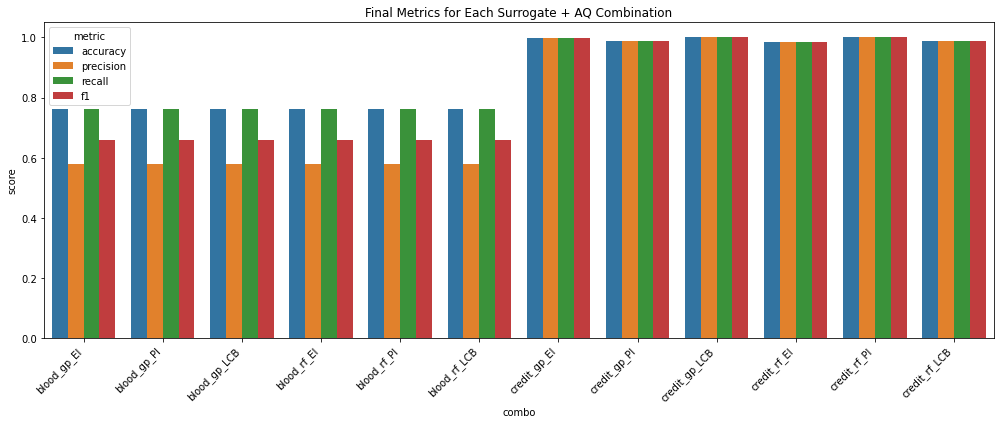

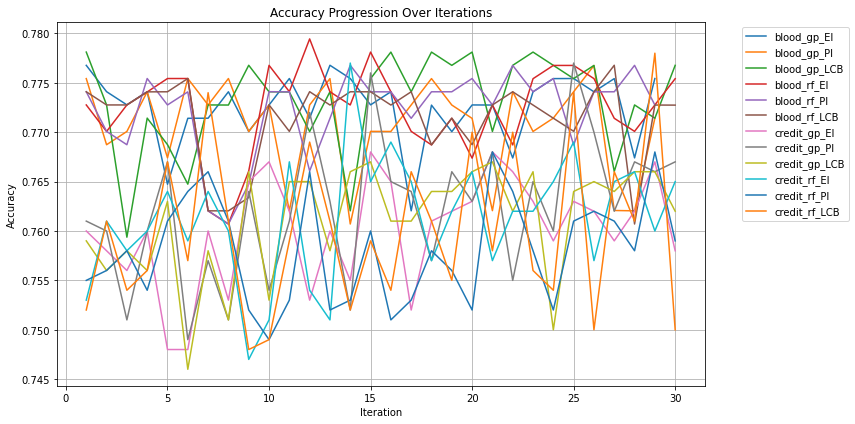

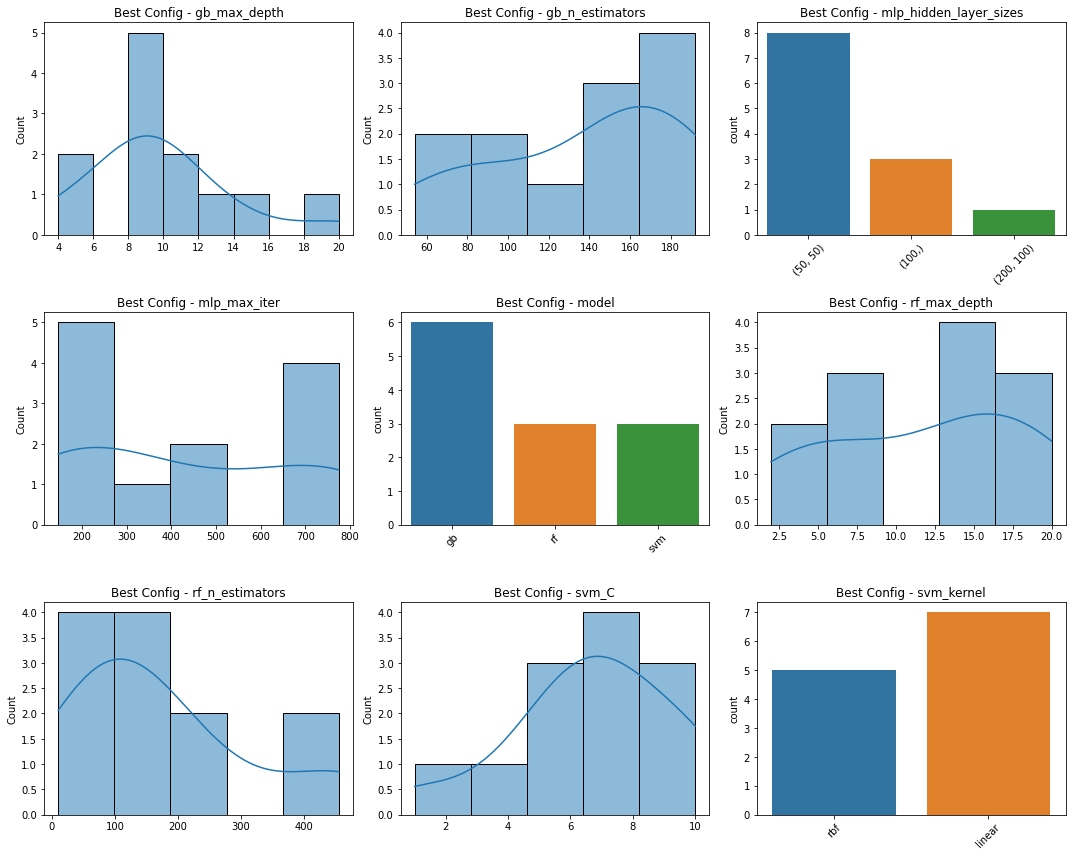

In [496]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections

# --- CONFIG: Toggle plot sections ---
PLOT_CONFIG_DISTRIBUTIONS = True  # Set to False to skip best_config distribution plot

# --- 1. Final Metrics Bar Plot ---
summary_data = []
for key, val in results.items():
    metrics = val['metrics']
    summary_data.append({
        'combo': key,
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1': metrics['f1']
    })

df_summary = pd.DataFrame(summary_data)
df_melted = df_summary.melt(id_vars='combo', var_name='metric', value_name='score')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='combo', y='score', hue='metric')
plt.xticks(rotation=45, ha='right')
plt.title('Final Metrics for Each Surrogate + AQ Combination')
plt.tight_layout()
plt.show()

# --- 2. Iterative Accuracy Progress Plot ---

# Patch accuracy progression from SMAC runhistory if not already present
for key, val in results.items():
    if "run_history" not in val or not val["run_history"]:
        smac_obj = val.get('smac')
        if smac_obj is None:
            continue
        runhistory = smac_obj.runhistory
        acc_scores = [1 - runvalue.cost for _, runvalue in runhistory.data.items()]
        val["run_history"] = [
            {"iteration": i + 1, "metrics": {"accuracy": acc}} for i, acc in enumerate(acc_scores)
        ]

# Plot accuracy over iterations
plt.figure(figsize=(12, 6))
for key, val in results.items():
    history = val.get('run_history', [])
    if not history:
        continue
    iterations = [entry['iteration'] for entry in history]
    acc_scores = [entry['metrics']['accuracy'] for entry in history]
    plt.plot(iterations, acc_scores, label=key)

plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Progression Over Iterations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# --- 3. Heatmap of F1 Score by Dataset vs Surrogate+AQ ---
heatmap_data = []
for key, val in results.items():
    try:
        dataset, surrogate, aq = key.split('-')
    except ValueError:
        continue  # skip malformed keys
    f1 = val['metrics']['f1']
    heatmap_data.append({
        'dataset': dataset,
        'combo': f'{surrogate}-{aq}',
        'f1': f1
    })

df_heat = pd.DataFrame(heatmap_data)
if not df_heat.empty:
    pivot = df_heat.pivot(index='dataset', columns='combo', values='f1')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title("F1 Score Heatmap: Dataset vs Surrogate+AQ")
    plt.tight_layout()
    plt.show()

# --- 4. Distribution of Best Config Parameter Values ---
if PLOT_CONFIG_DISTRIBUTIONS:
    all_params = collections.defaultdict(list)

    for key, val in results.items():
        config = val.get('best_config', {})
        try:
            cfg_dict = config.get_dictionary()
        except AttributeError:
            cfg_dict = config  # fallback if it's already a dict
        for param, value in cfg_dict.items():
            all_params[param].append(value)

    # Plot distributions
    n_params = len(all_params)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, (param, values) in enumerate(all_params.items()):
        ax = axes[idx]
        if all(isinstance(v, (int, float)) for v in values):
            sns.histplot(values, kde=True, ax=ax)
        else:
            sns.countplot(x=pd.Series(values), ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f"Best Config - {param}")

    for i in range(len(all_params), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
